### I want to mention first an important point , that there is some overlapping between the question answer order and the order of handeling the data , at some point , you will find that i'm answering question "2" as a code before answering question "1" , as i need to first clean the data before aggregating or merging the dataframes and so on

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
from scipy import stats
import scipy.stats as stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [ ]:
userscore_df = pd.read_csv("Documents/Data_Analytics/data/userscore.csv")

In [ ]:
merchants_df = pd.read_csv("Documents/Data_Analytics/data/merchants.csv")

In [ ]:
historical_transactions_df = pd.read_csv("Documents/Data_Analytics/data/historical_transactions.csv")

In [ ]:
new_merchant_transactions_df = pd.read_csv("Documents/Data_Analytics/data/new_merchant_transactions.csv")

# <font color='840e15'> Q1 </font>

### <font color='840e15'> Describe how you want to make use of merchants.csv, historical transactions.csv, and new merchant transactions.csv, for user loyalty prediction </font>

* After looking at the four files , it seems that they can't be handeled directly by just merging or concatenating them , but we need to do some aggregation function on each of the dataframes to get useful columns for the model to learn from.
* First for the historical transaction table and the new transaction table :-
> * I  will create a column that indicate the total number of purchases done by each card, this will be done by aggregating the "purchase date" column in order to know how many times each user purchased using the card.
> * I will also create a column that indicate the average amount of purchases for each user.
> * I will also create a column by aggregation that indicates the merchant which each unique user mostly deal with, in order to help me further join it with the merchants table
> * there will be column for aggregated installments
> * an aggregated column for most authorized flag "after encoding"
* Second for the merchant table :-
> * I will join it with the previously mentioned resulted datframes on the "merchant_id"
* Finally there will be one table that contains all data related to the user considering , number of transactions , amount of transactions , and all information about merchant that each unique user deal with ,and so on, along with the loyalty score

#### Final Trails were two :-

* Through first trail , i encode all the categorical features which lead to ==> RMSE: 3.5600581082894296
* Through second trail i tried to use most important numerical features which lead to ==> RMSE: 1.1633538290389736e-14 (R score: 1.0)(great progress)

==> You will find the code for implementing it further after data cleaning section

# userscore

In [ ]:
userscore_df.head(5)

,card_id,first_active_month,feature_1,feature_2,feature_3,score
0,C_ID_92a2005557,Jun-17,5,2,1,-0.820283
1,C_ID_3d0044924f,Jan-17,4,1,0,0.392913
2,C_ID_d639edf6cd,Aug-16,2,2,0,0.688056
3,C_ID_186d6a6901,Sep-17,4,3,0,0.142495
4,C_ID_cdbd2c0db2,Nov-17,1,3,0,-0.159749


In [ ]:
userscore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   card_id             201917 non-null  object 
 1   first_active_month  201917 non-null  object 
 2   feature_1           201917 non-null  int64  
 3   feature_2           201917 non-null  int64  
 4   feature_3           201917 non-null  int64  
 5   score               201917 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [ ]:
userscore_df[userscore_df.duplicated()]

,card_id,first_active_month,feature_1,feature_2,feature_3,score


There is no duplication

In [ ]:
nan_count = userscore_df.isna().sum()
nan_count

card_id               0
first_active_month    0
feature_1             0
feature_2             0
feature_3             0
score                 0
dtype: int64

There is no Nulls

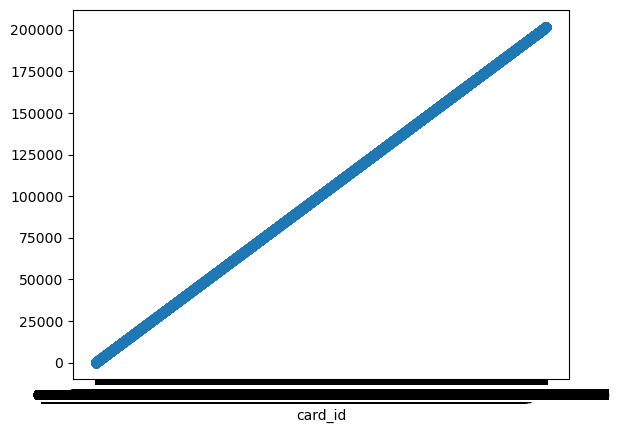

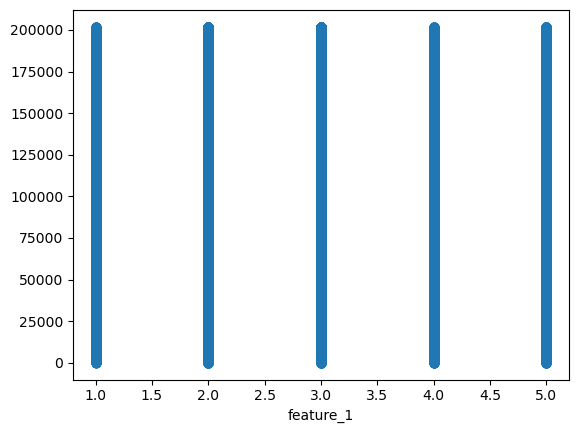

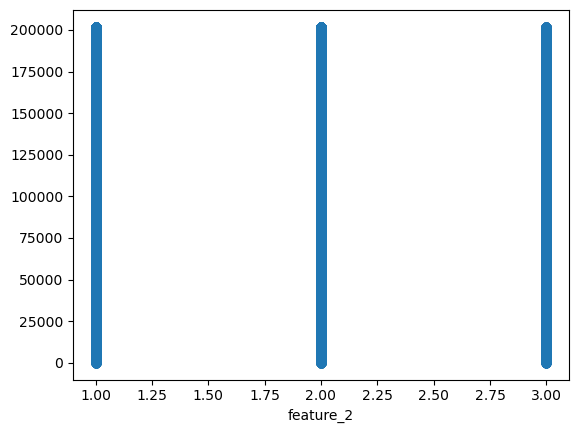

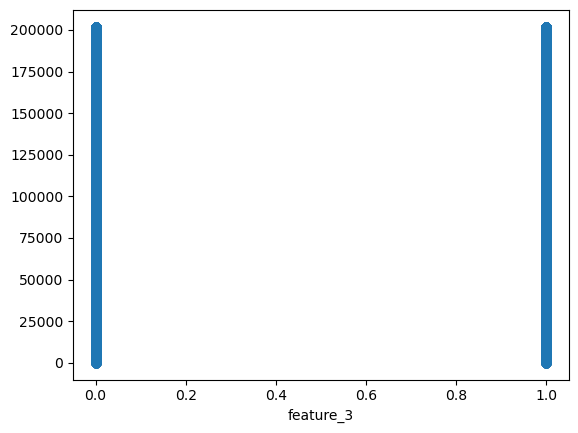

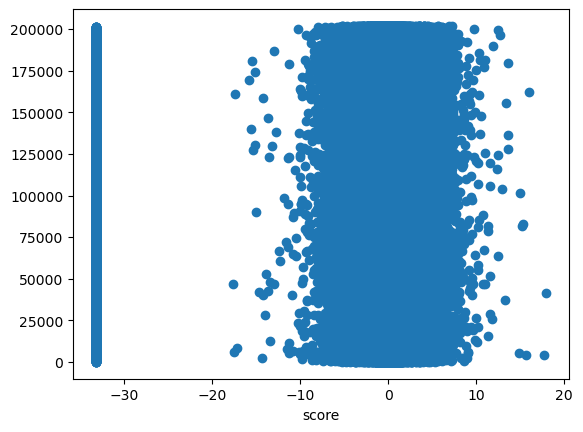

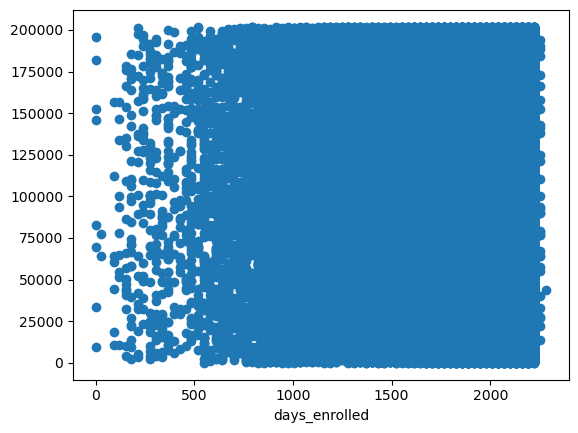

In [ ]:
# Create a scatter plot for each feature
for col in userscore_df.columns:
    plt.scatter(userscore_df[col], range(len(userscore_df)))
    plt.xlabel(col)
    plt.show()

In [ ]:
# Remove outliers from the 'variable_name' column using z-score approach
userscore_df['z_score'] = (userscore_df['feature_1'] - userscore_df['feature_1'].mean()) / userscore_df['feature_1'].std()
userscore_df = userscore_df[userscore_df['z_score'].abs() < 3]

# Remove outliers from the 'variable_name' column using z-score approach
userscore_df['z_score'] = (userscore_df['feature_2'] - userscore_df['feature_2'].mean()) / userscore_df['feature_2'].std()
userscore_df = userscore_df[userscore_df['z_score'].abs() < 3]

# Remove outliers from the 'variable_name' column using z-score approach
userscore_df['z_score'] = (userscore_df['feature_3'] - userscore_df['feature_3'].mean()) / userscore_df['feature_3'].std()
userscore_df = userscore_df[userscore_df['z_score'].abs() < 3]

# merchants

In [ ]:
merchants_df.head(5)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [ ]:
merchants_df.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')

In [ ]:
merchants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

In [ ]:
merchants_df[merchants_df.duplicated()]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2


In [ ]:
nan_count = merchants_df.isna().sum()
nan_count

merchant_id                    0
merchant_group_id              0
merchant_category_id           0
subsector_id                   0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
city_id                        0
state_id                       0
category_2                     0
z_score                        0
dtype: int64

<AxesSubplot:>

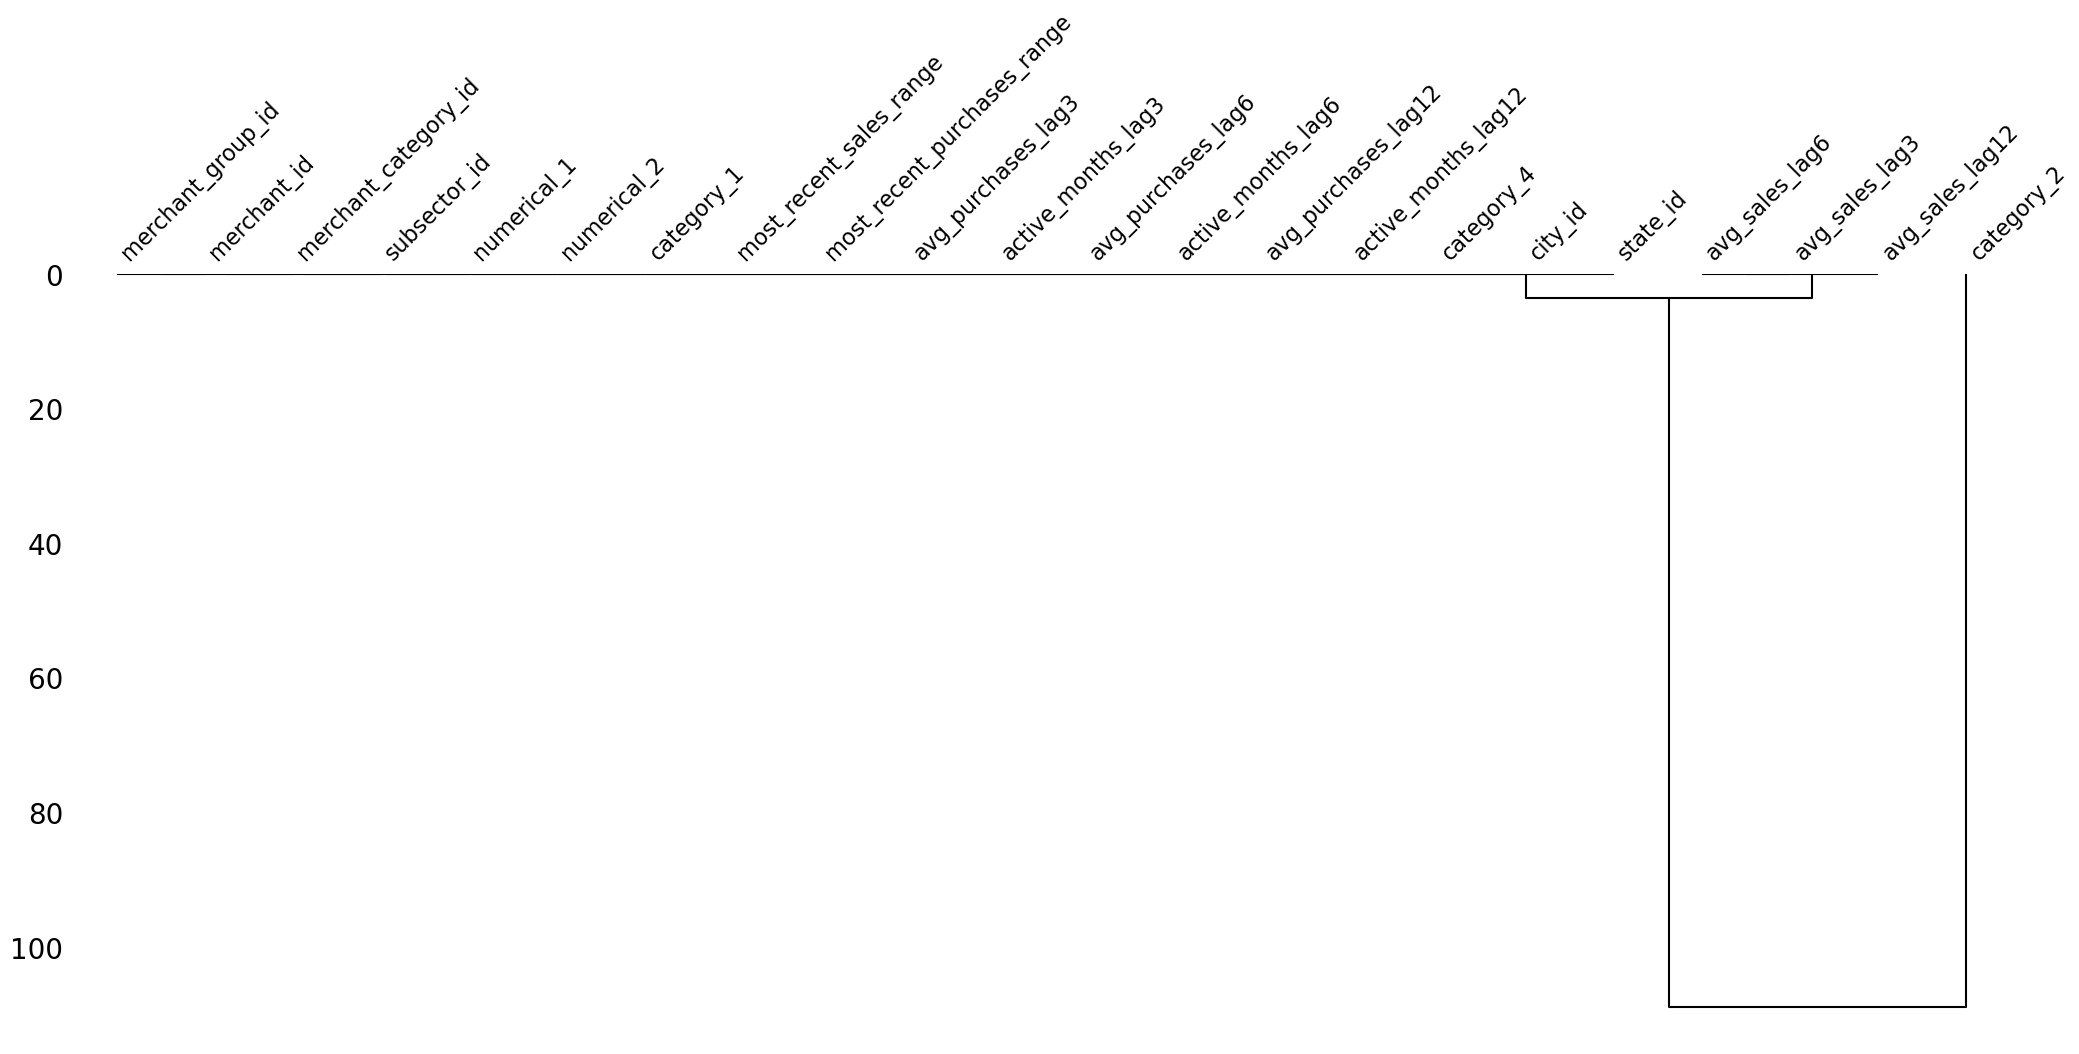

In [ ]:
msno.dendrogram(merchants_df)

<AxesSubplot:>

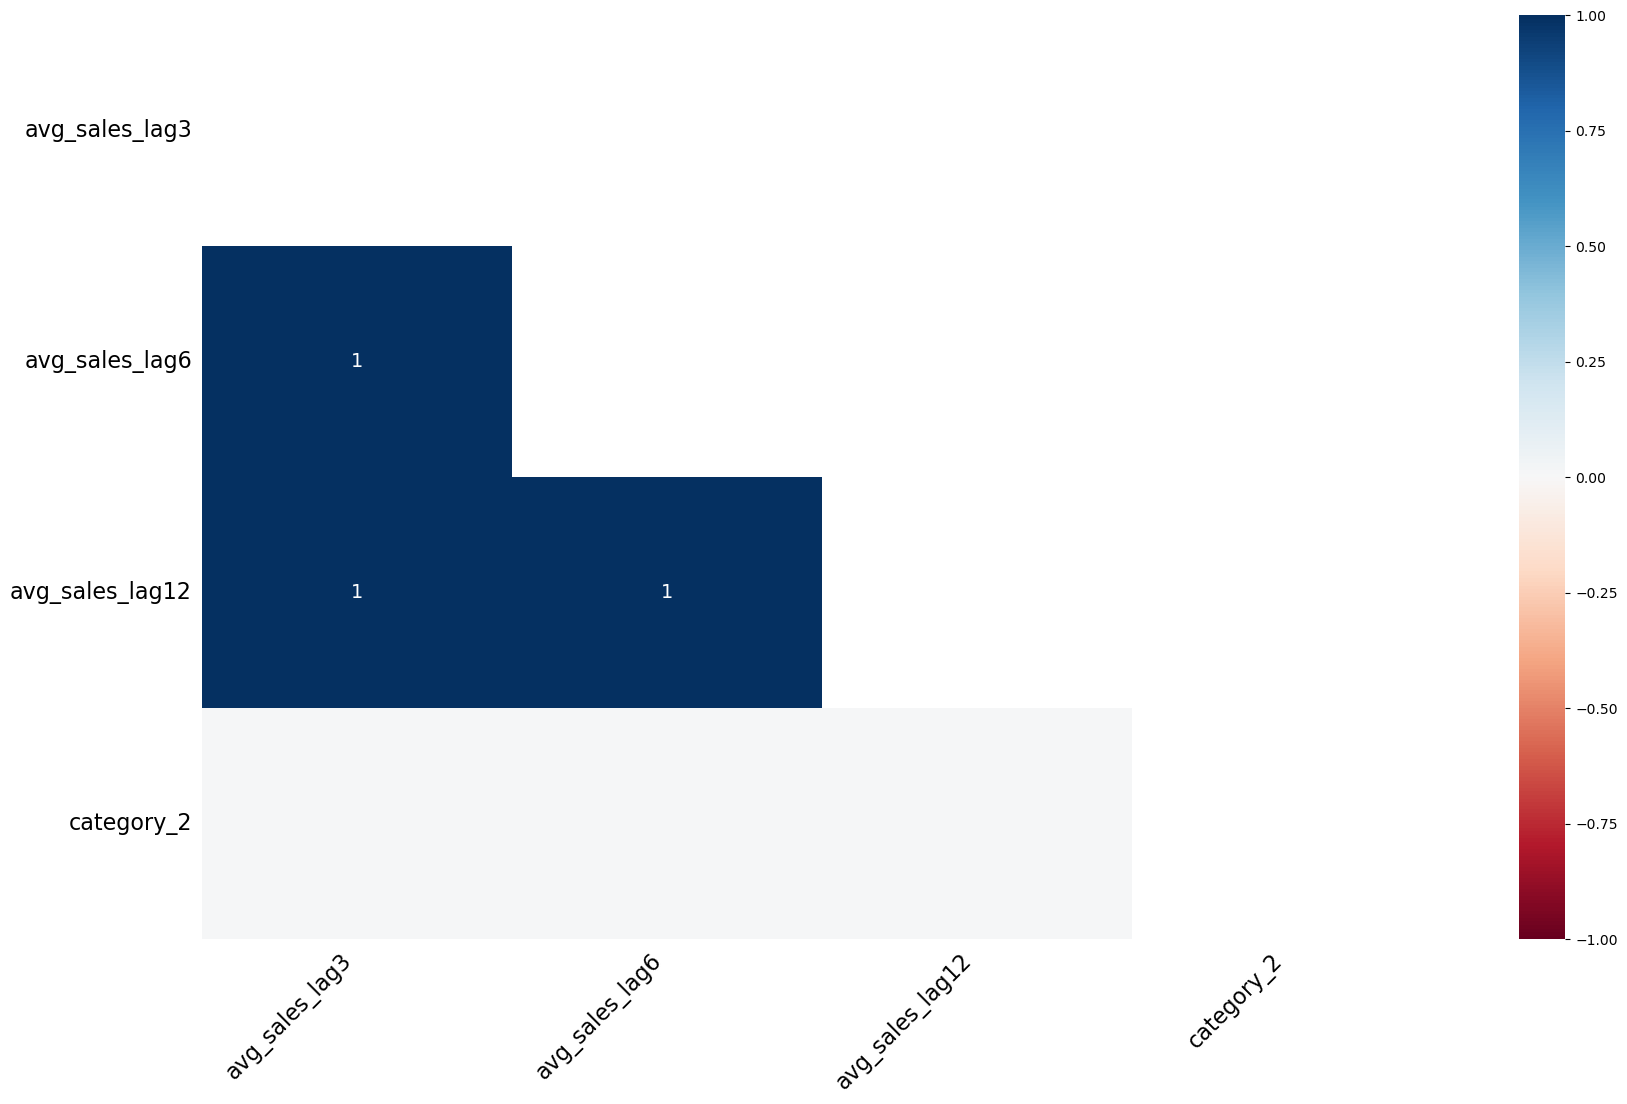

In [ ]:
msno.heatmap(merchants_df)

In [ ]:
# Test for normality using the Shapiro-Wilk test

column_name = "category_2"
column_data = merchants_df[column_name]
statistic, p_value = shapiro(column_data)

# Print the test result
if p_value > 0.05:
    print(f"The {column_name} column is normally distributed (p-value={p_value:.3f})")
else:
    print(f"The {column_name} column is not normally distributed (p-value={p_value:.3f})")

The category_2 column is normally distributed (p-value=1.000)


C:\Users\DEBI\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


it follow a normal distribution , i will impute with the mean

In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['category_2'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['category_2'] = merchants_df['category_2'].fillna(mean)

In [ ]:
# Test for normality using the Shapiro-Wilk test

column_name = "avg_sales_lag3"
column_data = merchants_df[column_name]
statistic, p_value = shapiro(column_data)

# Print the test result
if p_value > 0.05:
    print(f"The {column_name} column is normally distributed (p-value={p_value:.3f})")
else:
    print(f"The {column_name} column is not normally distributed (p-value={p_value:.3f})")

The avg_sales_lag3 column is normally distributed (p-value=1.000)


In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['avg_sales_lag3'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['avg_sales_lag3'] = merchants_df['avg_sales_lag3'].fillna(mean)

In [ ]:
column_name = "avg_sales_lag6"
column_data = merchants_df[column_name]
statistic, p_value = shapiro(column_data)

# Print the test result
if p_value > 0.05:
    print(f"The {column_name} column is normally distributed (p-value={p_value:.3f})")
else:
    print(f"The {column_name} column is not normally distributed (p-value={p_value:.3f})")

The avg_sales_lag6 column is normally distributed (p-value=1.000)


In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['avg_sales_lag6'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['avg_sales_lag6'] = merchants_df['avg_sales_lag6'].fillna(mean)

In [ ]:
column_name = "avg_sales_lag12"
column_data = merchants_df[column_name]
statistic, p_value = shapiro(column_data)

# Print the test result
if p_value > 0.05:
    print(f"The {column_name} column is normally distributed (p-value={p_value:.3f})")
else:
    print(f"The {column_name} column is not normally distributed (p-value={p_value:.3f})")

The avg_sales_lag12 column is normally distributed (p-value=1.000)


In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['avg_sales_lag12'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['avg_sales_lag12'] = merchants_df['avg_sales_lag12'].fillna(mean)

In [ ]:
nan_count = merchants_df.isna().sum()
nan_count

merchant_id                    0
merchant_group_id              0
merchant_category_id           0
subsector_id                   0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
city_id                        0
state_id                       0
category_2                     0
dtype: int64

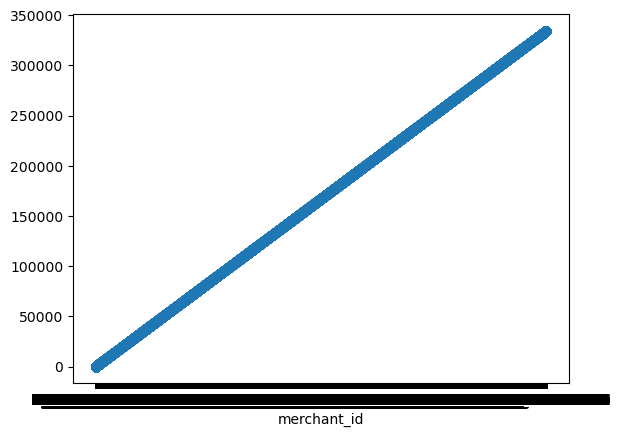

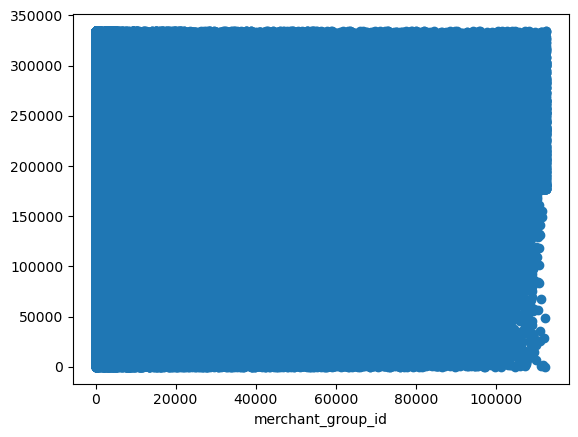

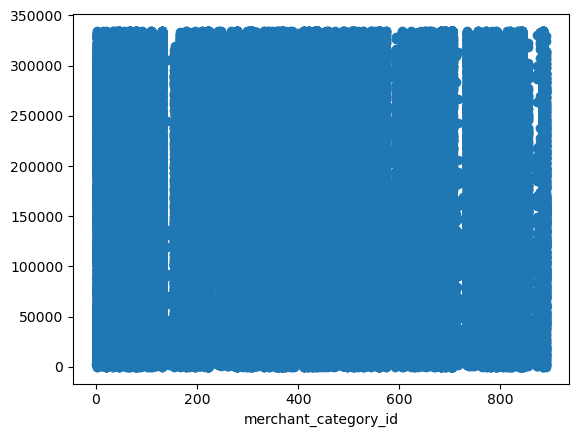

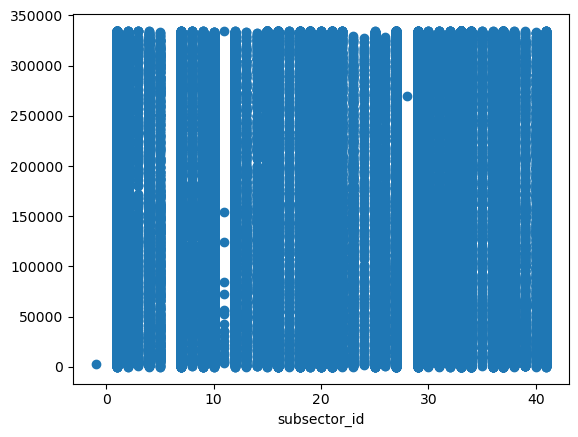

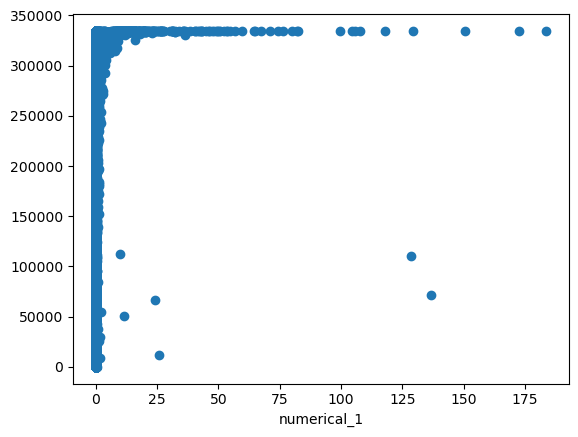

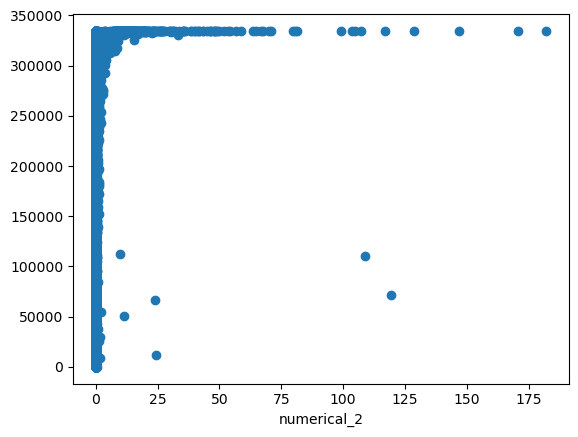

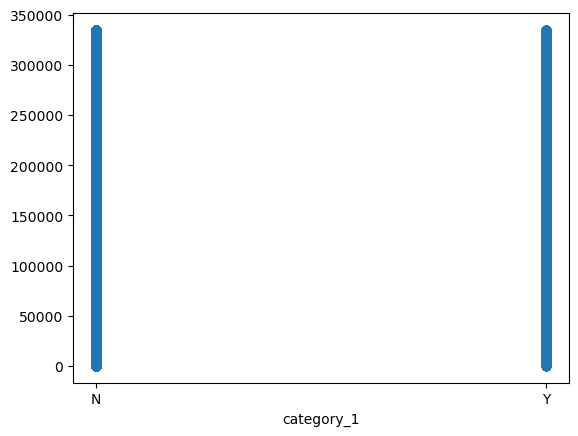

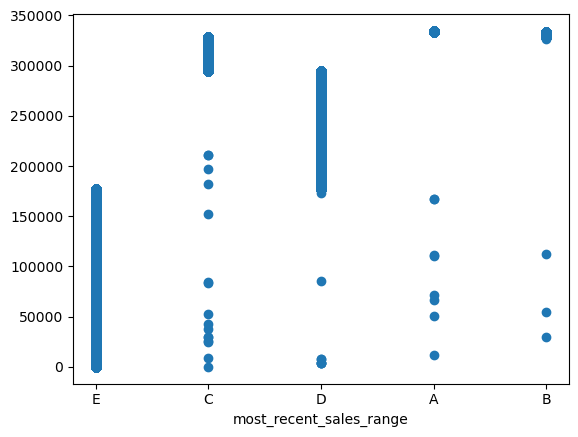

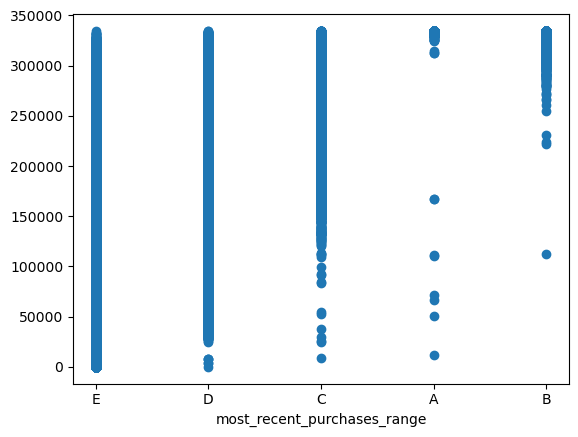

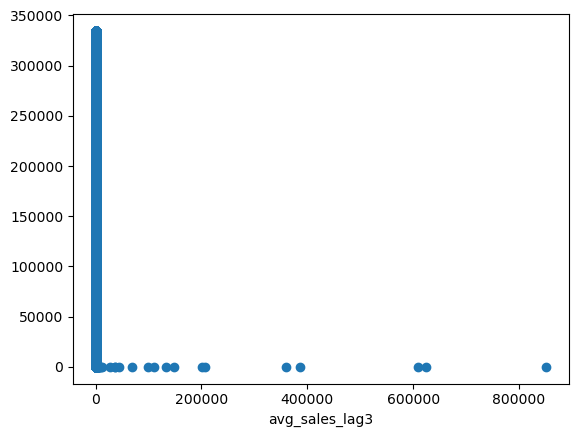

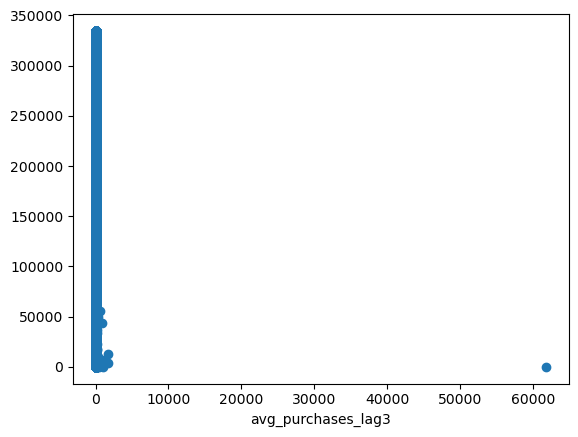

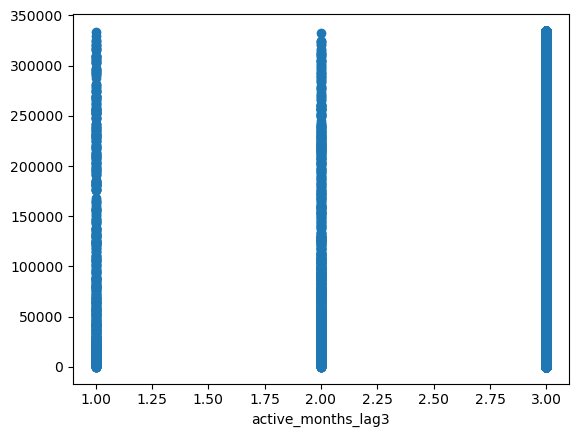

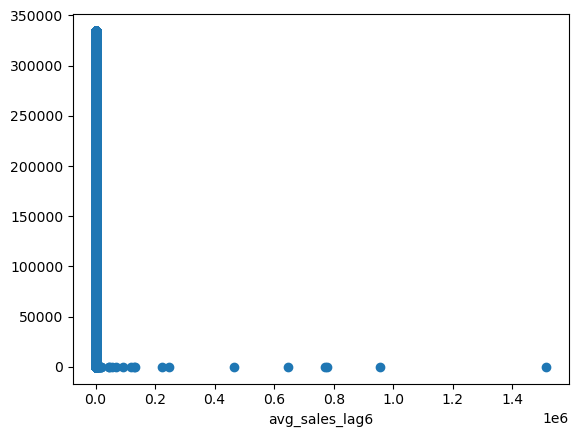

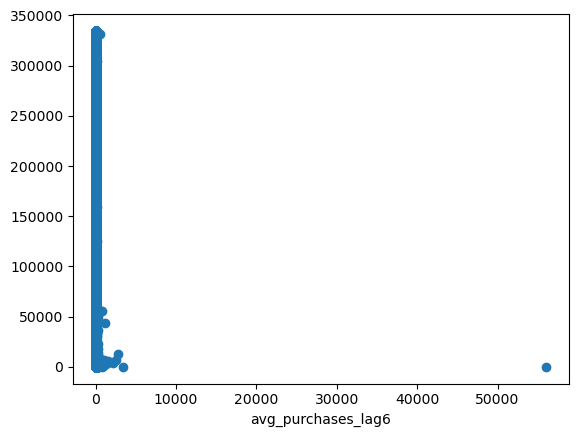

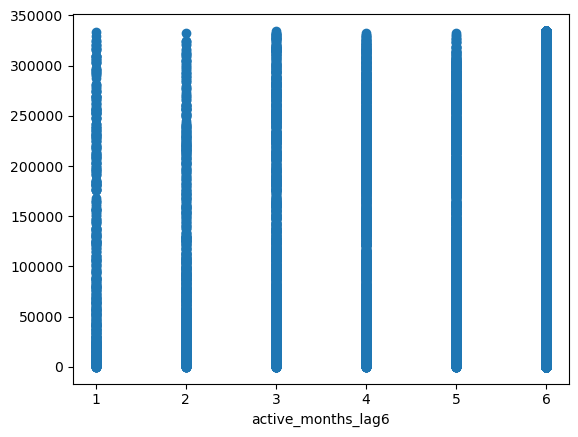

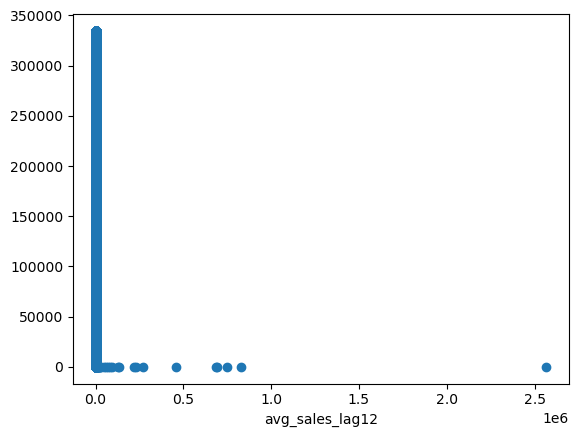

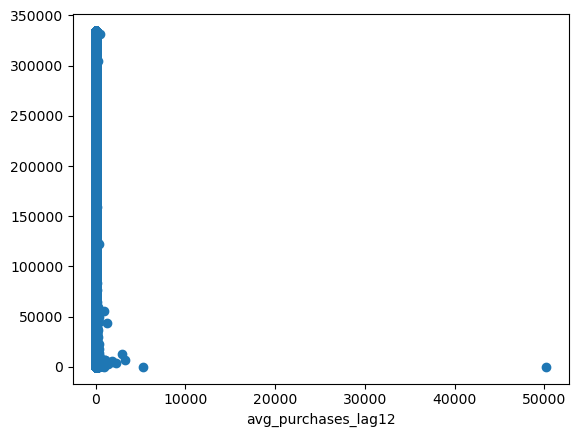

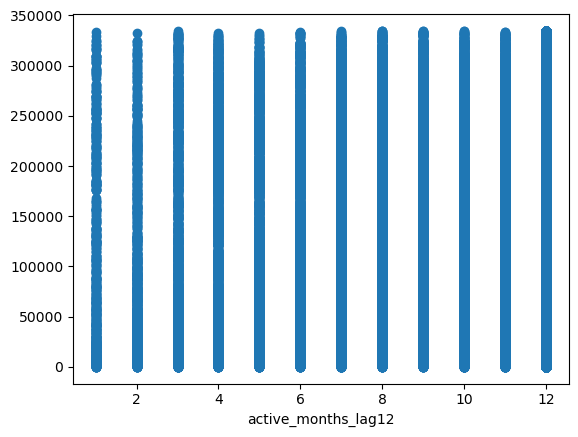

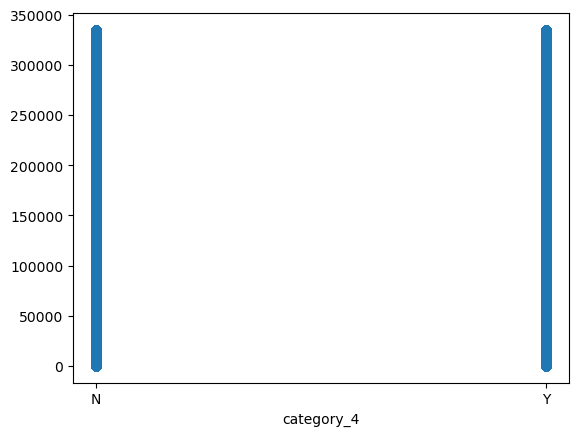

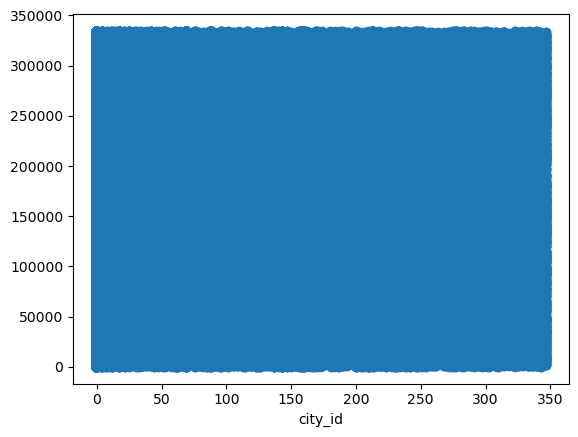

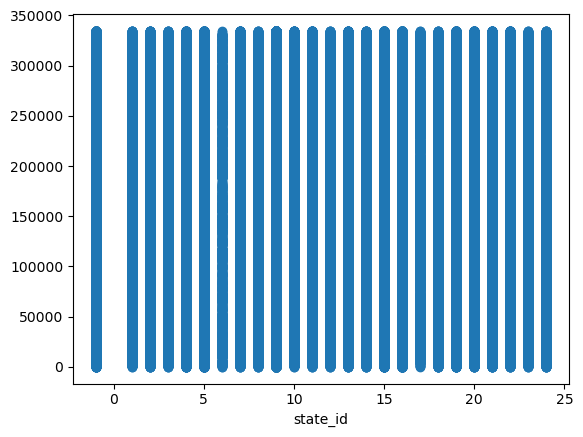

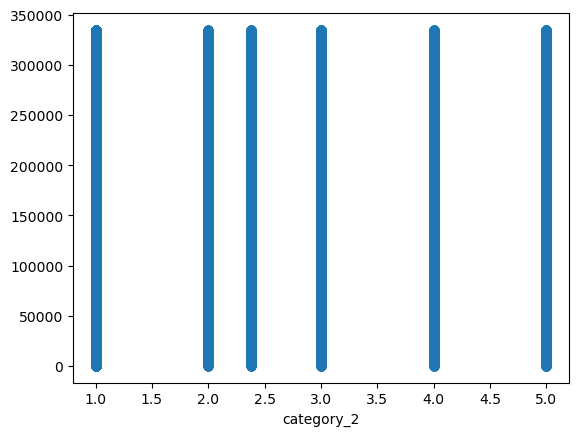

In [ ]:
# Create a scatter plot for each feature
for col in merchants_df.columns:
    plt.scatter(merchants_df[col], range(len(merchants_df)))
    plt.xlabel(col)
    plt.show()

In [ ]:
# Remove outliers from the 'variable_name' column using z-score approach
merchants_df['z_score'] = (merchants_df['numerical_1'] - merchants_df['numerical_1'].mean()) / merchants_df['numerical_1'].std()
merchants_df = merchants_df[merchants_df['z_score'].abs() < 2]

In [ ]:

# Remove outliers from the 'variable_name' column using z-score approach
merchants_df['z_score'] = (merchants_df['numerical_2'] - merchants_df['numerical_2'].mean()) / merchants_df['numerical_2'].std()
merchants_df = merchants_df[merchants_df['z_score'].abs() < 2]

In [ ]:

# Remove outliers from the 'variable_name' column using z-score approach
merchants_df['z_score'] = (merchants_df['avg_sales_lag3'] - merchants_df['avg_sales_lag3'].mean()) / merchants_df['avg_sales_lag3'].std()
merchants_df = merchants_df[merchants_df['z_score'].abs() < 2]

In [ ]:
# Remove outliers from the 'variable_name' column using z-score approach
merchants_df['z_score'] = (merchants_df['avg_sales_lag6'] - merchants_df['avg_sales_lag6'].mean()) / merchants_df['avg_sales_lag6'].std()
merchants_df = merchants_df[merchants_df['z_score'].abs() < 2]

In [ ]:
# Remove outliers from the 'variable_name' column using z-score approach
merchants_df['z_score'] = (merchants_df['avg_sales_lag12'] - merchants_df['avg_sales_lag12'].mean()) / merchants_df['avg_sales_lag12'].std()
merchants_df = merchants_df[merchants_df['z_score'].abs() < 2]

In [ ]:
# Remove outliers from the 'variable_name' column using z-score approach
merchants_df['z_score'] = (merchants_df['avg_purchases_lag3'] - merchants_df['avg_purchases_lag3'].mean()) / merchants_df['avg_purchases_lag3'].std()
merchants_df = merchants_df[merchants_df['z_score'].abs() < 2]

In [ ]:
# Remove outliers from the 'variable_name' column using z-score approach
merchants_df['z_score'] = (merchants_df['avg_purchases_lag6'] - merchants_df['avg_purchases_lag6'].mean()) / merchants_df['avg_purchases_lag6'].std()
merchants_df = merchants_df[merchants_df['z_score'].abs() < 2]


In [ ]:
# Remove outliers from the 'variable_name' column using z-score approach
merchants_df['z_score'] = (merchants_df['avg_purchases_lag6'] - merchants_df['avg_purchases_lag12'].mean()) / merchants_df['avg_purchases_lag12'].std()
merchants_df = merchants_df[merchants_df['z_score'].abs() < 2]

# historical_transactions

#### second table needed to be merged

* in order to be able to merge this table info with the user score, i want to get only one record for each unique merchant, and then , join it to the user score after knowing which merchant does the user deals with most, so as to relate it witht the user loyalty

In [ ]:
historical_transactions_df.head(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,-0.734887,2018-02-24 08:45:05,1.0,9,37
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,-0.716855,2017-03-21 00:10:51,1.0,16,37
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,-0.657049,2017-11-18 20:05:55,1.0,16,37
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,-0.737967,2017-06-01 22:02:56,1.0,16,37
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,-0.715352,2017-03-16 15:41:22,1.0,16,37


In [ ]:
historical_transactions_df.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [ ]:
historical_transactions_df[historical_transactions_df.duplicated()]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id


In [ ]:
nan_count = historical_transactions_df.isna().sum()
nan_count

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

<AxesSubplot:>

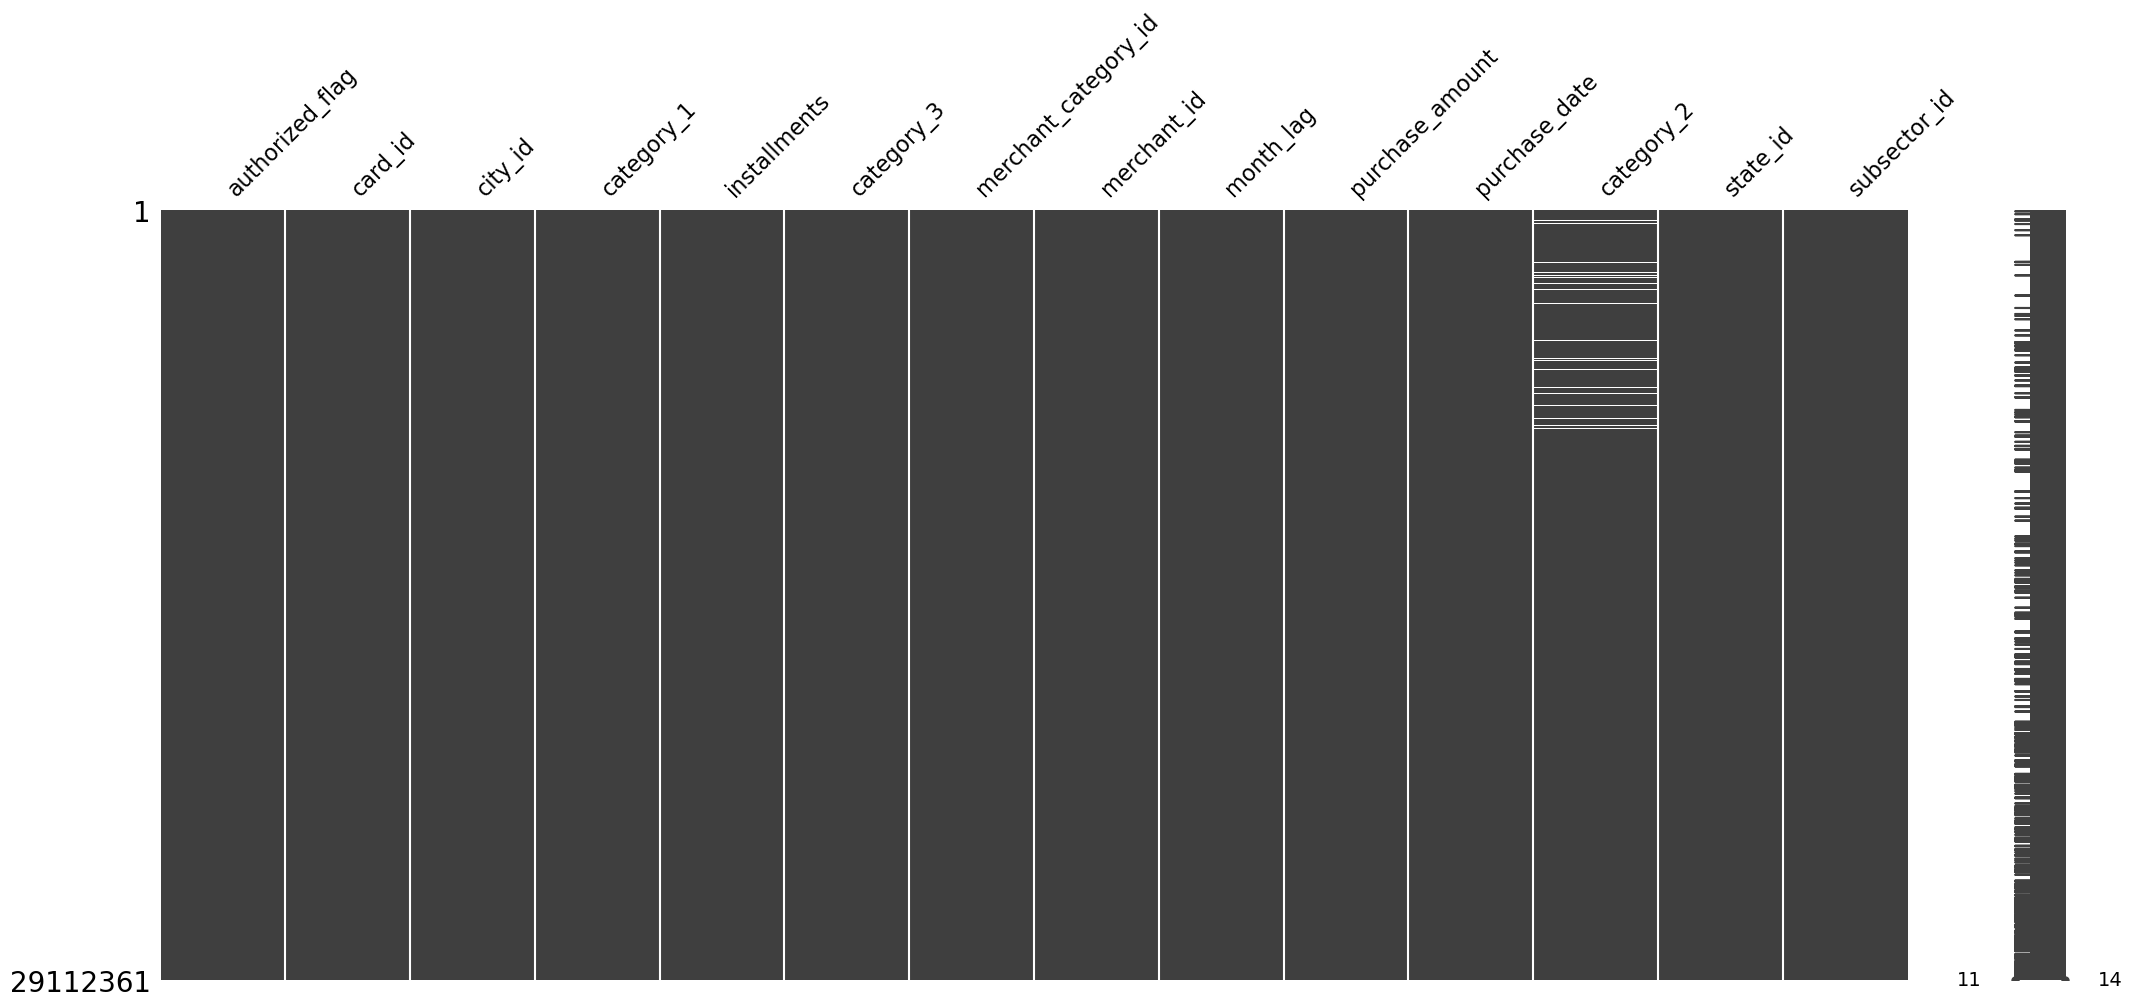

In [ ]:
msno.matrix(historical_transactions_df)

In [ ]:
column_name = "category_2"
column_data = historical_transactions_df[column_name]
statistic, p_value = shapiro(column_data)

# Print the test result
if p_value > 0.05:
    print(f"The {column_name} column is normally distributed (p-value={p_value:.3f})")
else:
    print(f"The {column_name} column is not normally distributed (p-value={p_value:.3f})")

The category_2 column is normally distributed (p-value=1.000)


C:\Users\DEBI\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# Calculate the mean of 'column2'
mean = historical_transactions_df['category_2'].mean()

# Replace missing values in 'column2' with the mean
historical_transactions_df['category_2'] = historical_transactions_df['category_2'].fillna(mean)

In [ ]:
# Calculate the mode of 'column2'
mode = historical_transactions_df['category_3'].mode()[0]

# Replace missing values in 'column2' with the mode
historical_transactions_df['category_3'] = historical_transactions_df['category_3'].fillna(mode)

In [ ]:
nan_count = historical_transactions_df.isna().sum()
nan_count

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3                   0
merchant_category_id         0
merchant_id             131274
month_lag                    0
purchase_amount              0
purchase_date                0
category_2                   0
state_id                     0
subsector_id                 0
dtype: int64

In [ ]:
new_merchant_transactions_df.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [ ]:
new_merchant_transactions_df.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [ ]:
new_merchant_transactions_df[new_merchant_transactions_df.duplicated()]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id


In [ ]:
nan_count = new_merchant_transactions_df.isna().sum()
nan_count

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

In [ ]:
mean = new_merchant_transactions_df['category_2'].mean()

# Replace missing values in 'column2' with the mean
new_merchant_transactions_df['category_2'] = new_merchant_transactions_df['category_2'].fillna(mean)

In [ ]:
# Calculate the mode of 'column2'
mode = new_merchant_transactions_df['category_3'].mode()[0]

# Replace missing values in 'column2' with the mode
new_merchant_transactions_df['category_3'] = new_merchant_transactions_df['category_3'].fillna(mode)

# <font color='840e15'> Q2 </font>

### <font color='840e15'> Discuss the quality of the dataset, considering missing values, missing value patterns, missing value mechanism, and noise (e.g.,consistency) </font>

* considering duplication , there is no duplicates in any of the tables.
* considering missing values :-
> *  userscore table => has no missing values
> * Merchant table :-
>> * "avg_sales_lag3", "avg_sales_lag6", "avg_sales_lag12" ==> have the same number of missing values, and since the data is too large , it's pattern can't be recognized through the matrix , i needed a dendrogram and heatmap to interperet the missing , i think the pattern of the three is ==>> "unit non-response pattern", and the mechanism is  ==> MNAR
>> * "category_2" ==> Univariate pattern , and the mechanism is MCAR
>> * "category_3" ==> Univariate pattern , and the mechanism is MCAR
> * Historical transactions table  :-
>> * "category_2" ==> Univariate pattern , and the mechanism is MCAR
>> * "category_3" ==> Univariate pattern , and the mechanism is MCAR
> * new transactions table  :-
>> * "category_2" ==> Univariate pattern , and the mechanism is MCAR
>> * "category_3" ==> Univariate pattern , and the mechanism is MCAR

# <font color='840e15'> Q3 </font>

### <font color='840e15'> Perform necessary data cleaning based on your answer to Q2.</font>

* I checked the duplicates
* I checked and imputed the Nulls ( each with the most appropriate method , depending on whether being normally distributed or not )
* I removed the outliers
* I will further encode the categorical feature to numeric before the model section
* I will need to also split the date and convert it's type by converting it to sum of days since specific date

# <font color='840e15'> Q4 </font>

### <font color='840e15'> Report important statistics in preprocessed data created in Q3. The target user loyalty score must be covered in the statistical analysis. </font>

In [ ]:
data.describe(include="all")

,card_id,first_active_month,feature_1,feature_2,feature_3,score,z_score,num_purchases,purchase_amount,merchant_id,...,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_2,num_purchases_new_x,num_purchases_new_y
count,144242,144242.000000,144242.000000,144242.000000,144242.000000,144242.000000,144242.000000,144242.000000,1.442420e+05,144242,...,144242.000000,144242.000000,144242.000000,144242.000000,144242.000000,144242.000000,144242.000000,144242.000000,144242.000000,144242.000000
unique,144242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,C_ID_92a2005557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M_ID_00a6ca8a8a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1913.284002,3.107528,1.734148,0.554353,-0.448589,-0.022627,90.889325,2.396558e+01,NaN,...,2.999868,1.015419,1.013269,5.999196,1.028404,1.021880,11.968477,2.220470,6.684752,6.684752
std,NaN,290.000717,1.201822,0.757619,0.497039,3.556998,1.002734,104.336551,1.588624e+04,NaN,...,0.014659,0.161233,0.123741,0.050778,0.259278,0.242824,0.338809,1.290329,6.595588,6.595588
min,NaN,0.000000,1.000000,1.000000,0.000000,-33.219281,-1.140989,2.000000,-1.242352e+03,NaN,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,NaN,1796.000000,2.000000,1.000000,0.000000,-0.920470,-1.140989,28.000000,-6.658585e+01,NaN,...,3.000000,1.000000,1.000000,6.000000,1.000000,1.000000,12.000000,1.000000,2.000000,2.000000
50%,NaN,1978.000000,3.000000,2.000000,1.000000,-0.081368,0.876429,57.000000,-3.106461e+01,NaN,...,3.000000,1.000000,1.000000,6.000000,1.000000,1.000000,12.000000,2.000000,5.000000,5.000000
75%,NaN,2131.000000,4.000000,2.000000,1.000000,0.664171,0.876429,113.000000,-1.286181e+01,NaN,...,3.000000,1.000000,1.000000,6.000000,1.000000,1.000000,12.000000,3.000000,9.000000,9.000000


# <font color='840e15'> Q5 </font>

### <font color='840e15'>Propose two hypothesis tests exploring information related to user loyalty score. For each hypothesis test, you must describe the motivation (why this hypothesis is interesting and important to test), null hypothesis, and select a proper statistical test to report the test result</font>

* i will check the most frequent city that is being purchased from, cause there may be a relation between the loyalty of the customer and certain city that being purchased from

In [ ]:
grouped_city_per_card = historical_transactions_df.groupby('card_id')['city_id'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
grouped_city_per_card.head(5)

,card_id,city_id
0,C_ID_00007093c1,244
1,C_ID_0001238066,314
2,C_ID_0001506ef0,137
3,C_ID_0001793786,179
4,C_ID_000183fdda,161


In [ ]:
grouped_city_per_card.columns

Index(['merchant_id', 'city_id'], dtype='object')

In [ ]:
most_frequent_value = grouped_city_per_card['city_id'].value_counts().index[0]

In [ ]:
most_frequent_value

69

In [ ]:
grouped_city_per_card_2 = new_merchant_transactions_df.groupby('card_id')['city_id'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
grouped_city_per_card.head(5)

,merchant_id,city_id
0,M_ID_000025127f,69
1,M_ID_0000699140,48
2,M_ID_00006a5552,64
3,M_ID_000087311e,-1
4,M_ID_0000ab0b2d,-1


In [ ]:
most_frequent_value = grouped_city_per_card_2['city_id'].value_counts().index[0]

In [ ]:
most_frequent_value

69

* the null hypothesis  H0 is that all cities result in the same loyalty as "69" and alternative hypothesis  H1 is that city "69" result in different loyalty

In [ ]:
historical_and_new = pd.concat([grouped_city_per_card, userscore_df])

In [ ]:
city_with_user = pd.merge(grouped_city_per_card, userscore_df, on='card_id', how='inner')

In [ ]:
city_with_user.head(10)

,card_id,city_id,first_active_month,feature_1,feature_2,feature_3,score
0,C_ID_00007093c1,244,2017-02-01,5,1,1,0.134077
1,C_ID_0001506ef0,137,2016-07-01,2,2,0,0.884295
2,C_ID_000183fdda,161,2017-09-01,4,1,0,-0.264433
3,C_ID_00027503e2,146,2017-05-01,3,1,1,0.812872
4,C_ID_0002c7c2c1,69,2017-04-01,3,2,1,1.288514
5,C_ID_0003be3c83,279,2017-08-01,2,3,0,-0.083268
6,C_ID_00042d509c,-1,2017-07-01,2,1,0,-1.264398
7,C_ID_0004888ddd,286,2017-07-01,2,2,0,0.512450
8,C_ID_0004b68c49,69,2017-09-01,3,1,1,2.070528
9,C_ID_0004c2a5ab,-1,2014-10-01,5,1,1,-0.537806


In [ ]:
df1 = city_with_user[city_with_user['city_id'] == 69]  # DataFrame of dates before January 3, 2022
df2 = city_with_user[city_with_user['city_id'] != 69]  # DataFrame of dates on or after January 3, 2022

In [ ]:
sample1 = df1['score'].tolist()
sample2 = df2['score'].tolist()

In [ ]:
# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(sample1, sample2)

# Print the results
print('Mann-Whitney U test statistic:', stat)
print('p-value:', p)

Mann-Whitney U test statistic: 2129188095.5
p-value: 0.32457865016907783


* the H0 indicated that users who usually purchase through city "69" are same as others concerning loyalty
* the H1 indicated that users who usually purchasr through city "69" are different from others concerning loyalty

#### This ensures that city "69" as we reject the hypothesis test , so that loyalty of most users who purchesd through this city is different from loyalty of others

In [ ]:
# compute the mean of the first column in the first data frame
mean1 = df1['score'].mean()

# compute the mean of the first column in the second data frame
mean2 = df2['score'].mean()

# compare the means and print the result
if mean1 > mean2:
    print("The mean of score in the ""69"" city is greater.")
elif mean2 > mean1:
    print("The mean of score in the other frame is greater.")
else:
    print("The means are equal.")

The mean of SALE PRICE in the other frame is greater.


I will now test whether that at some years users were more loyal or not

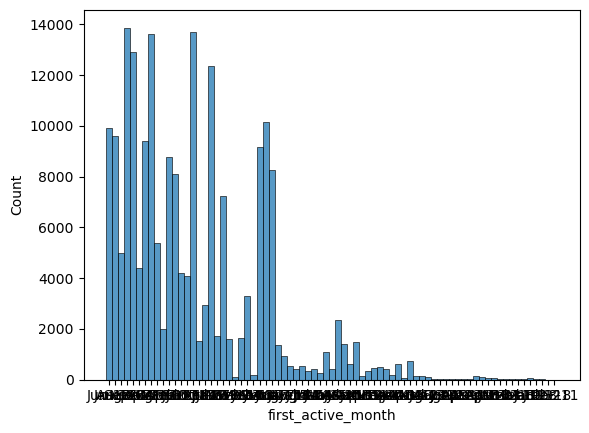

In [ ]:
sns.histplot(data=userscore_df, x='first_active_month')
plt.show()

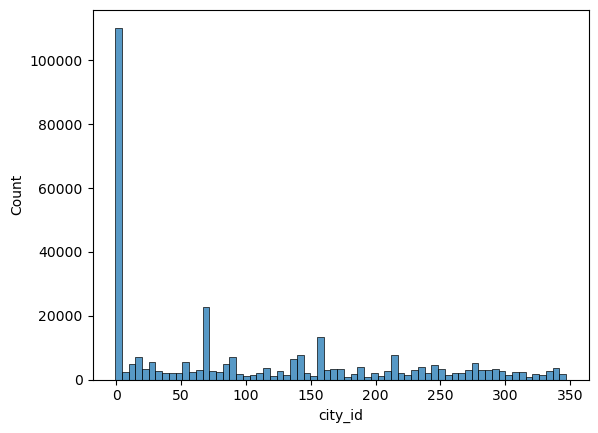

In [ ]:
sns.histplot(data=merchants_df, x='city_id')
plt.show()

In [ ]:
userscore_df['first_active_month'] = pd.to_datetime(userscore_df['first_active_month'], format='%b-%y')

C:\Users\DEBI\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


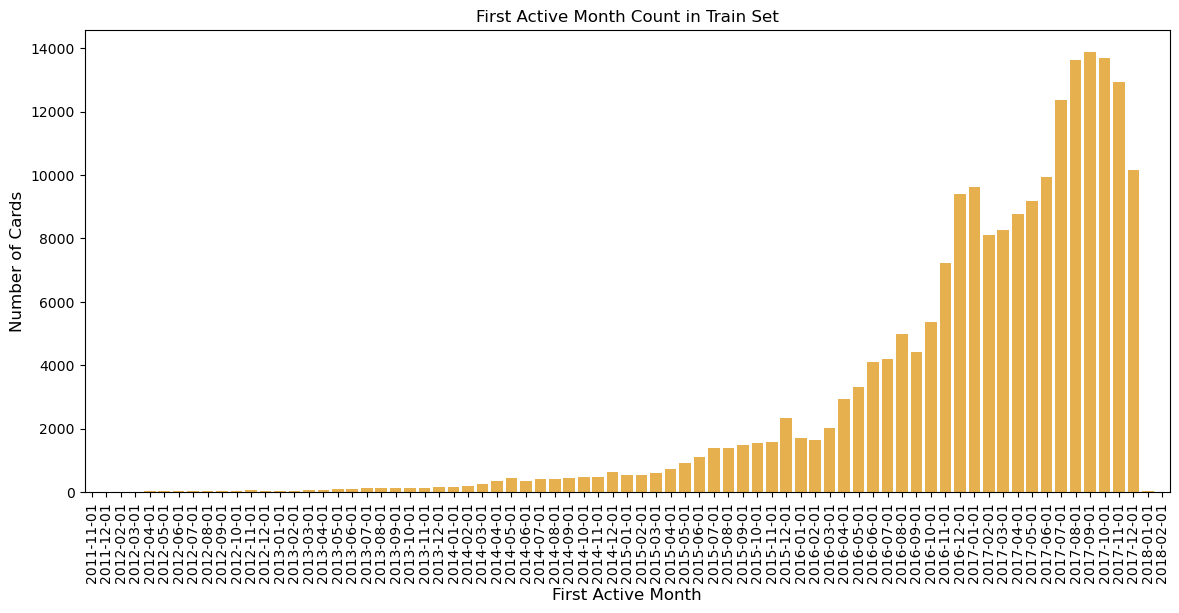

In [ ]:
cnt_srs = userscore_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14, 6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='orange')
plt.xticks(rotation='vertical')
plt.xlabel('First Active Month', fontsize=12)
plt.ylabel('Number of Cards', fontsize=12)
plt.title("First Active Month Count in Train Set")
plt.show()

In [ ]:
scores_per_month = userscore_df.groupby('first_active_month')['score'].mean().reset_index()

In [ ]:
scores_per_month

,first_active_month,score
0,2011-11-01,-0.815126
1,2011-12-01,0.318033
2,2012-02-01,-1.015259
3,2012-03-01,-0.296254
4,2012-04-01,-5.946395
...,...,...
70,2017-10-01,-0.038316
71,2017-11-01,-0.017814
72,2017-12-01,-0.051228
73,2018-01-01,0.171985


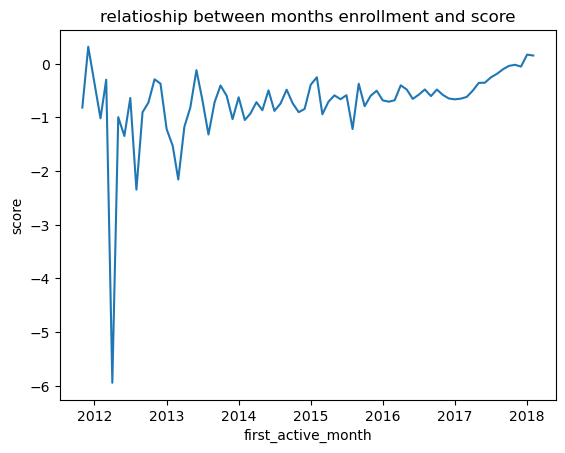

In [ ]:
# Create the line plot
plt.plot(scores_per_month['first_active_month'], scores_per_month['score'])

# Add labels and title
plt.xlabel('first_active_month')
plt.ylabel('score')
plt.title('relatioship between months enrollment and score')

# Show the plot
plt.show()

In [ ]:
scores_per_month['first_active_month']

0    2011-11-01
1    2011-12-01
2    2012-02-01
3    2012-03-01
4    2012-04-01
        ...    
70   2017-10-01
71   2017-11-01
72   2017-12-01
73   2018-01-01
74   2018-02-01
Name: first_active_month, Length: 75, dtype: datetime64[ns]

In [ ]:
df1 = scores_per_month[scores_per_month['first_active_month'] < '2017-01-01']  # DataFrame of dates before
df2 = scores_per_month[scores_per_month['first_active_month'] > '2017-01-01']  # DataFrame of dates on or after

In [ ]:
sample1 = df1['score'].tolist()
sample2 = df2['score'].tolist()

In [ ]:
# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(sample1, sample2)

# Print the results
print('Mann-Whitney U test statistic:', stat)
print('p-value:', p)

Mann-Whitney U test statistic: 85.0
p-value: 9.98151208178315e-06


* the H0 indicated that users who usually activated their account before 2017 are same as others concerning loyalty
* the H1 indicated that users who usually activated their account after 2017 are different from others concerning loyalty

#### there is very strong evidence to accept the null hypothesis

In [ ]:
# compute the mean of the first column in the first data frame
mean1 = df1['score'].mean()

# compute the mean of the first column in the second data frame
mean2 = df2['score'].mean()

# compare the means and print the result
if mean1 > mean2:
    print("The mean of score before 2017 is greater.")
elif mean2 > mean1:
    print("The mean of score after 2017 is greater.")
else:
    print("The means are equal.")

The mean of score after 2017 is greater.


# <font color='840e15'> Q6 </font>

### <font color='840e15'>Create a regression model for user loyalty score prediction based on the above analysis. You need to determine what features to use and which regression model to use</font>

# Pipeline Trail (1)

Through this trail i will take all the categorical features in consideration

In [ ]:
userscore_df = pd.read_csv("Documents/Data_Analytics/data/userscore.csv")

In [ ]:
merchants_df = pd.read_csv("Documents/Data_Analytics/data/merchants.csv")

In [ ]:
historical_transactions_df = pd.read_csv("Documents/Data_Analytics/data/historical_transactions.csv")

In [ ]:
new_merchant_transactions_df = pd.read_csv("Documents/Data_Analytics/data/new_merchant_transactions.csv")

In [ ]:
userscore_df['first_active_month'] = pd.to_datetime(userscore_df['first_active_month'], format='%b-%y')

In [ ]:
userscore_df['first_active_month']

0        2017-06-01
1        2017-01-01
2        2016-08-01
3        2017-09-01
4        2017-11-01
            ...    
201912   2017-09-01
201913   2015-10-01
201914   2017-08-01
201915   2016-07-01
201916   2017-07-01
Name: first_active_month, Length: 201917, dtype: datetime64[ns]

In [ ]:
# getting the first date to consider it as a refrence date
first_date = userscore_df['first_active_month'].min()

# Print the first date
first_date

Timestamp('2011-11-01 00:00:00')

In [ ]:
# Convert the 'date_column' to number of days since January 1, 1970
ref_date = pd.to_datetime('2011-11-01')
userscore_df['days_enrolled'] = (pd.to_datetime(userscore_df['first_active_month']) - ref_date).dt.days

In [ ]:
userscore_df = userscore_df.drop('first_active_month', axis=1)

In [ ]:
userscore_df.columns

Index(['card_id', 'feature_1', 'feature_2', 'feature_3', 'score',
       'days_enrolled'],
      dtype='object')

In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['avg_sales_lag3'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['avg_sales_lag3'] = merchants_df['avg_sales_lag3'].fillna(mean)

In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['avg_sales_lag6'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['avg_sales_lag6'] = merchants_df['avg_sales_lag6'].fillna(mean)

In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['avg_sales_lag12'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['avg_sales_lag12'] = merchants_df['avg_sales_lag12'].fillna(mean)

In [ ]:
# Calculate the mean of 'column2'
mean = historical_transactions_df['category_2'].mean()

# Replace missing values in 'column2' with the mean
historical_transactions_df['category_2'] = historical_transactions_df['category_2'].fillna(mean)

In [ ]:
merchants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   merchant_id                  334696 non-null  object  
 1   numerical_1                  334696 non-null  float64 
 2   numerical_2                  334696 non-null  float64 
 3   category_1                   334696 non-null  object  
 4   most_recent_sales_range      334696 non-null  category
 5   most_recent_purchases_range  334696 non-null  category
 6   avg_sales_lag3               334696 non-null  float64 
 7   avg_purchases_lag3           334696 non-null  float64 
 8   active_months_lag3           334696 non-null  int64   
 9   avg_sales_lag6               334696 non-null  float64 
 10  avg_purchases_lag6           334696 non-null  float64 
 11  active_months_lag6           334696 non-null  int64   
 12  avg_sales_lag12              334696 non-null

In [ ]:
merchants_df = merchants_df.drop('subsector_id', axis=1)

In [ ]:
merchants_df = merchants_df.drop('state_id', axis=1)

In [ ]:
merchants_df = merchants_df.drop('city_id', axis=1)

In [ ]:
merchants_df = merchants_df.drop('merchant_group_id', axis=1)

In [ ]:
merchants_df = merchants_df.drop('merchant_category_id', axis=1)

In [ ]:
unique_val = merchants_df['category_1'].unique()
unique_val

array(['N', 'Y'], dtype=object)

In [ ]:
unique_val = merchants_df['category_4'].unique()
unique_val

array(['N', 'Y'], dtype=object)

* factorize() can be a useful alternative to one-hot encoding when dealing with categorical variables with a small number of unique values

In [ ]:
merchants_df['category_1_factorized'] = pd.factorize(merchants_df['category_1'])[0]

In [ ]:
merchants_df = merchants_df.drop('category_1', axis=1)

In [ ]:
merchants_df['category_4_factorized'] = pd.factorize(merchants_df['category_4'])[0]

In [ ]:
merchants_df = merchants_df.drop('category_4', axis=1)

In [ ]:
unique_val = merchants_df['most_recent_sales_range'].unique()
unique_val

array(['E', 'C', 'D', 'A', 'B'], dtype=object)

In [ ]:
merchants_df['most_recent_sales_range'] = merchants_df['most_recent_sales_range'].astype('category')


In [ ]:
unique_val = merchants_df['most_recent_purchases_range'].unique()
unique_val

array(['E', 'D', 'C', 'A', 'B'], dtype=object)

In [ ]:
merchants_df['most_recent_purchases_range'] = merchants_df['most_recent_purchases_range'].astype('category')


In [ ]:
le = LabelEncoder()

# perform label encoding on the 'Gender' column
merchants_df['most_recent_sales_range_encoded'] = le.fit_transform(merchants_df['most_recent_sales_range'])

In [ ]:
merchants_df['most_recent_purchases_range_encoded'] = le.fit_transform(merchants_df['most_recent_purchases_range'])

In [ ]:
merchants_df.columns

Index(['merchant_id', 'numerical_1', 'numerical_2', 'avg_sales_lag3',
       'avg_purchases_lag3', 'active_months_lag3', 'avg_sales_lag6',
       'avg_purchases_lag6', 'active_months_lag6', 'avg_sales_lag12',
       'avg_purchases_lag12', 'active_months_lag12', 'category_2',
       'most_recent_sales_range_encoded',
       'most_recent_purchases_range_encoded', 'category_1_factorized',
       'category_4_factorized'],
      dtype='object')

In [ ]:
merchants_df = merchants_df.drop('most_recent_sales_range', axis=1)
merchants_df = merchants_df.drop('most_recent_purchases_range', axis=1)

In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['category_2'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['category_2'] = merchants_df['category_2'].fillna(mean)

In [ ]:
merchants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 17 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   merchant_id                          334696 non-null  object 
 1   numerical_1                          334696 non-null  float64
 2   numerical_2                          334696 non-null  float64
 3   avg_sales_lag3                       334696 non-null  float64
 4   avg_purchases_lag3                   334696 non-null  float64
 5   active_months_lag3                   334696 non-null  int64  
 6   avg_sales_lag6                       334696 non-null  float64
 7   avg_purchases_lag6                   334696 non-null  float64
 8   active_months_lag6                   334696 non-null  int64  
 9   avg_sales_lag12                      334696 non-null  float64
 10  avg_purchases_lag12                  334696 non-null  float64
 11  active_months

In [ ]:
historical_transactions_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,0,C_ID_4e6213e9bc,88,0,0,1.0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,0,C_ID_4e6213e9bc,88,0,0,1.0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,0,C_ID_4e6213e9bc,88,0,0,1.0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,0,C_ID_4e6213e9bc,88,0,0,1.0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,0,C_ID_4e6213e9bc,88,0,0,1.0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [ ]:
historical_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28934014 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       int64  
 1   card_id               object 
 2   city_id               int64  
 3   category_1            int64  
 4   installments          int64  
 5   category_3            float64
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 3.2+ GB


In [ ]:
nan_count = historical_transactions_df.isna().sum()
nan_count

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3                   0
merchant_category_id         0
merchant_id             131274
month_lag                    0
purchase_amount              0
purchase_date                0
category_2                   0
state_id                     0
subsector_id                 0
dtype: int64

In [ ]:
unique_val = historical_transactions_df['installments'].unique()
unique_val

array([ 0,  1,  5,  3,  4,  2, 10,  6, 12,  8,  7,  9, 11], dtype=int64)

In [ ]:
# Calculate the mode of 'column2'
mode = historical_transactions_df['category_3'].mode()[0]

# Replace missing values in 'column2' with the mode
historical_transactions_df['category_3'] = historical_transactions_df['category_3'].fillna(mode)

In [ ]:
# Calculate the mode of 'column2'
mode = historical_transactions_df['category_2'].mode()[0]

# Replace missing values in 'column2' with the mode
historical_transactions_df['category_2'] = historical_transactions_df['category_2'].fillna(mode)

In [ ]:
historical_transactions_df = historical_transactions_df[historical_transactions_df['installments'] != -1]

In [ ]:
historical_transactions_df = historical_transactions_df[historical_transactions_df['installments'] != 999]

In [ ]:
unique_val = historical_transactions_df['authorized_flag'].unique()
unique_val

array([0, 1], dtype=int64)

In [ ]:
historical_transactions_df['authorized_flag'] = pd.factorize(historical_transactions_df['authorized_flag'])[0]

In [ ]:
unique_val = historical_transactions_df['category_1'].unique()
unique_val

array([0, 1], dtype=int64)

In [ ]:
historical_transactions_df['category_1'] = pd.factorize(historical_transactions_df['category_1'])[0]

In [ ]:
unique_val = historical_transactions_df['category_3'].unique()
unique_val

array([1., 3., 5., 2., 4.])

In [ ]:
historical_transactions_df['category_3'] = le.fit_transform(historical_transactions_df['category_3'])

In [ ]:
historical_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28934014 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       int64  
 1   card_id               object 
 2   city_id               int64  
 3   category_1            int64  
 4   installments          int64  
 5   category_3            int64  
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 3.2+ GB


In [ ]:
# now the first thing to do is to get the most merchant dealt with for each user , in order to merge it with the merchants

In [ ]:
# for each card i need the most merchant dealt with
grouped_merchants_per_card = historical_transactions_df.groupby('card_id')['merchant_id'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
grouped_merchants_per_card.head(5)

,card_id,merchant_id
0,C_ID_00007093c1,M_ID_9400cf2342
1,C_ID_0001238066,M_ID_d17aabd756
2,C_ID_0001506ef0,M_ID_b1fc88154d
3,C_ID_0001793786,M_ID_923d57de8d
4,C_ID_000183fdda,M_ID_f9cfe0a43b


In [ ]:
merged = pd.merge(grouped_merchants_per_card, userscore_df, on='card_id', how='inner')
merged

,card_id,merchant_id,feature_1,feature_2,feature_3,score,days_enrolled
0,C_ID_00007093c1,M_ID_9400cf2342,5,1,1,0.134077,1919
1,C_ID_0001506ef0,M_ID_b1fc88154d,2,2,0,0.884295,1704
2,C_ID_000183fdda,M_ID_f9cfe0a43b,4,1,0,-0.264433,2131
3,C_ID_00027503e2,M_ID_8de747a1c2,3,1,1,0.812872,2008
4,C_ID_0002c7c2c1,M_ID_f40ccc1312,3,2,1,1.288514,1978
...,...,...,...,...,...,...,...
201912,C_ID_fffeced303,M_ID_e5374dabc0,2,1,0,0.362965,1978
201913,C_ID_fffeed3a89,M_ID_1704588c56,4,3,0,-0.085357,2192
201914,C_ID_ffff579d3a,M_ID_f0ada5d0c0,2,2,0,1.530061,2100
201915,C_ID_ffff828181,M_ID_181cf8c379,2,1,0,-0.600063,1157


In [ ]:
# for each card i need the number of purchases
historical_transactions_counts = historical_transactions_df.groupby('card_id')['purchase_date'].count().reset_index()

In [ ]:
historical_transactions_counts = historical_transactions_counts.rename(columns={'purchase_date': 'num_purchases'})

In [ ]:
historical_transactions_counts

,card_id,num_purchases
0,C_ID_00007093c1,149
1,C_ID_0001238066,120
2,C_ID_0001506ef0,66
3,C_ID_0001793786,216
4,C_ID_000183fdda,140
...,...,...
325535,C_ID_ffff1d9928,11
325536,C_ID_ffff579d3a,114
325537,C_ID_ffff756266,24
325538,C_ID_ffff828181,189


In [ ]:
merged = pd.merge(merged, historical_transactions_counts, on='card_id', how='inner')
merged

,card_id,merchant_id,feature_1,feature_2,feature_3,score,days_enrolled,num_purchases
0,C_ID_00007093c1,M_ID_9400cf2342,5,1,1,0.134077,1919,149
1,C_ID_0001506ef0,M_ID_b1fc88154d,2,2,0,0.884295,1704,66
2,C_ID_000183fdda,M_ID_f9cfe0a43b,4,1,0,-0.264433,2131,140
3,C_ID_00027503e2,M_ID_8de747a1c2,3,1,1,0.812872,2008,42
4,C_ID_0002c7c2c1,M_ID_f40ccc1312,3,2,1,1.288514,1978,67
...,...,...,...,...,...,...,...,...
201912,C_ID_fffeced303,M_ID_e5374dabc0,2,1,0,0.362965,1978,186
201913,C_ID_fffeed3a89,M_ID_1704588c56,4,3,0,-0.085357,2192,163
201914,C_ID_ffff579d3a,M_ID_f0ada5d0c0,2,2,0,1.530061,2100,114
201915,C_ID_ffff828181,M_ID_181cf8c379,2,1,0,-0.600063,1157,189


In [ ]:
# for each card i need the avergae amount of purchases
purchase_amount = historical_transactions_df.groupby('card_id')['purchase_amount'].sum().reset_index()

In [ ]:
purchase_amount

,card_id,purchase_amount
0,C_ID_00007093c1,-76.845041
1,C_ID_0001238066,-71.925556
2,C_ID_0001506ef0,-34.601879
3,C_ID_0001793786,-36.786013
4,C_ID_000183fdda,-67.242183
...,...,...
325535,C_ID_ffff1d9928,-7.061349
325536,C_ID_ffff579d3a,-80.292768
325537,C_ID_ffff756266,-5.506420
325538,C_ID_ffff828181,-119.739977


In [ ]:
merged = pd.merge(purchase_amount, merged, on='card_id', how='inner')
merged

,card_id,purchase_amount,merchant_id,feature_1,feature_2,feature_3,score,days_enrolled,num_purchases
0,C_ID_00007093c1,-76.845041,M_ID_9400cf2342,5,1,1,0.134077,1919,149
1,C_ID_0001506ef0,-34.601879,M_ID_b1fc88154d,2,2,0,0.884295,1704,66
2,C_ID_000183fdda,-67.242183,M_ID_f9cfe0a43b,4,1,0,-0.264433,2131,140
3,C_ID_00027503e2,-31.123047,M_ID_8de747a1c2,3,1,1,0.812872,2008,42
4,C_ID_0002c7c2c1,-44.183670,M_ID_f40ccc1312,3,2,1,1.288514,1978,67
...,...,...,...,...,...,...,...,...,...
201912,C_ID_fffeced303,-127.602809,M_ID_e5374dabc0,2,1,0,0.362965,1978,186
201913,C_ID_fffeed3a89,-81.574364,M_ID_1704588c56,4,3,0,-0.085357,2192,163
201914,C_ID_ffff579d3a,-80.292768,M_ID_f0ada5d0c0,2,2,0,1.530061,2100,114
201915,C_ID_ffff828181,-119.739977,M_ID_181cf8c379,2,1,0,-0.600063,1157,189


In [ ]:
# for each card i need the most merchant dealt with
grouped_category_1_per_card_hist = historical_transactions_df.groupby('card_id')['category_1'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
print("Mode of 'your_data_column' by 'your_group_column':")
grouped_category_1_per_card_hist.head(5)

Mode of 'your_data_column' by 'your_group_column':


,card_id,category_1
0,C_ID_00007093c1,0
1,C_ID_0001238066,0
2,C_ID_0001506ef0,0
3,C_ID_0001793786,0
4,C_ID_000183fdda,0


In [ ]:
merged = pd.merge(grouped_category_1_per_card_hist, merged, on='card_id', how='inner')
merged

,card_id,category_1,purchase_amount,merchant_id,feature_1,feature_2,feature_3,score,days_enrolled,num_purchases
0,C_ID_00007093c1,0,-76.845041,M_ID_9400cf2342,5,1,1,0.134077,1919,149
1,C_ID_0001506ef0,0,-34.601879,M_ID_b1fc88154d,2,2,0,0.884295,1704,66
2,C_ID_000183fdda,0,-67.242183,M_ID_f9cfe0a43b,4,1,0,-0.264433,2131,140
3,C_ID_00027503e2,0,-31.123047,M_ID_8de747a1c2,3,1,1,0.812872,2008,42
4,C_ID_0002c7c2c1,0,-44.183670,M_ID_f40ccc1312,3,2,1,1.288514,1978,67
...,...,...,...,...,...,...,...,...,...,...
201912,C_ID_fffeced303,1,-127.602809,M_ID_e5374dabc0,2,1,0,0.362965,1978,186
201913,C_ID_fffeed3a89,0,-81.574364,M_ID_1704588c56,4,3,0,-0.085357,2192,163
201914,C_ID_ffff579d3a,0,-80.292768,M_ID_f0ada5d0c0,2,2,0,1.530061,2100,114
201915,C_ID_ffff828181,0,-119.739977,M_ID_181cf8c379,2,1,0,-0.600063,1157,189


In [ ]:
# for each card i need the most merchant dealt with
grouped_authorized_flag_per_card_hist = historical_transactions_df.groupby('card_id')['authorized_flag'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
print("Mode of 'your_data_column' by 'your_group_column':")
grouped_authorized_flag_per_card_hist.head(5)

Mode of 'your_data_column' by 'your_group_column':


,card_id,authorized_flag
0,C_ID_00007093c1,0
1,C_ID_0001238066,0
2,C_ID_0001506ef0,0
3,C_ID_0001793786,0
4,C_ID_000183fdda,0


In [ ]:
merged = pd.merge(grouped_authorized_flag_per_card_hist, merged, on='card_id', how='inner')
merged

,card_id,authorized_flag,category_1,purchase_amount,merchant_id,feature_1,feature_2,feature_3,score,days_enrolled,num_purchases
0,C_ID_00007093c1,0,0,-76.845041,M_ID_9400cf2342,5,1,1,0.134077,1919,149
1,C_ID_0001506ef0,0,0,-34.601879,M_ID_b1fc88154d,2,2,0,0.884295,1704,66
2,C_ID_000183fdda,0,0,-67.242183,M_ID_f9cfe0a43b,4,1,0,-0.264433,2131,140
3,C_ID_00027503e2,0,0,-31.123047,M_ID_8de747a1c2,3,1,1,0.812872,2008,42
4,C_ID_0002c7c2c1,0,0,-44.183670,M_ID_f40ccc1312,3,2,1,1.288514,1978,67
...,...,...,...,...,...,...,...,...,...,...,...
201912,C_ID_fffeced303,0,1,-127.602809,M_ID_e5374dabc0,2,1,0,0.362965,1978,186
201913,C_ID_fffeed3a89,0,0,-81.574364,M_ID_1704588c56,4,3,0,-0.085357,2192,163
201914,C_ID_ffff579d3a,0,0,-80.292768,M_ID_f0ada5d0c0,2,2,0,1.530061,2100,114
201915,C_ID_ffff828181,0,0,-119.739977,M_ID_181cf8c379,2,1,0,-0.600063,1157,189


In [ ]:
# for each card i need the most merchant dealt with
grouped_category_3_per_card_hist = historical_transactions_df.groupby('card_id')['category_3'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
print("Mode of 'your_data_column' by 'your_group_column':")
grouped_category_3_per_card_hist.head(5)

Mode of 'your_data_column' by 'your_group_column':


,card_id,category_3
0,C_ID_00007093c1,2
1,C_ID_0001238066,0
2,C_ID_0001506ef0,2
3,C_ID_0001793786,0
4,C_ID_000183fdda,2


In [ ]:
merged = pd.merge(grouped_category_3_per_card_hist, merged, on='card_id', how='inner')
merged

,card_id,category_3,authorized_flag,category_1,purchase_amount,merchant_id,feature_1,feature_2,feature_3,score,days_enrolled,num_purchases
0,C_ID_00007093c1,2,0,0,-76.845041,M_ID_9400cf2342,5,1,1,0.134077,1919,149
1,C_ID_0001506ef0,2,0,0,-34.601879,M_ID_b1fc88154d,2,2,0,0.884295,1704,66
2,C_ID_000183fdda,2,0,0,-67.242183,M_ID_f9cfe0a43b,4,1,0,-0.264433,2131,140
3,C_ID_00027503e2,2,0,0,-31.123047,M_ID_8de747a1c2,3,1,1,0.812872,2008,42
4,C_ID_0002c7c2c1,0,0,0,-44.183670,M_ID_f40ccc1312,3,2,1,1.288514,1978,67
...,...,...,...,...,...,...,...,...,...,...,...,...
201912,C_ID_fffeced303,0,0,1,-127.602809,M_ID_e5374dabc0,2,1,0,0.362965,1978,186
201913,C_ID_fffeed3a89,0,0,0,-81.574364,M_ID_1704588c56,4,3,0,-0.085357,2192,163
201914,C_ID_ffff579d3a,0,0,0,-80.292768,M_ID_f0ada5d0c0,2,2,0,1.530061,2100,114
201915,C_ID_ffff828181,1,0,0,-119.739977,M_ID_181cf8c379,2,1,0,-0.600063,1157,189


In [ ]:
# for each card i need the most merchant dealt with
installments_per_card = historical_transactions_df.groupby('card_id')['installments'].sum().reset_index()

In [ ]:
installments_per_card.head()

,card_id,installments
0,C_ID_00007093c1,192
1,C_ID_0001238066,201
2,C_ID_0001506ef0,1
3,C_ID_0001793786,5
4,C_ID_000183fdda,268


In [ ]:
merged = pd.merge(installments_per_card, merged, on='card_id', how='inner')
merged

,card_id,installments,category_3,authorized_flag,category_1,purchase_amount,merchant_id,feature_1,feature_2,feature_3,score,days_enrolled,num_purchases
0,C_ID_00007093c1,192,2,0,0,-76.845041,M_ID_9400cf2342,5,1,1,0.134077,1919,149
1,C_ID_0001506ef0,1,2,0,0,-34.601879,M_ID_b1fc88154d,2,2,0,0.884295,1704,66
2,C_ID_000183fdda,268,2,0,0,-67.242183,M_ID_f9cfe0a43b,4,1,0,-0.264433,2131,140
3,C_ID_00027503e2,0,2,0,0,-31.123047,M_ID_8de747a1c2,3,1,1,0.812872,2008,42
4,C_ID_0002c7c2c1,0,0,0,0,-44.183670,M_ID_f40ccc1312,3,2,1,1.288514,1978,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,C_ID_fffeced303,213,0,0,1,-127.602809,M_ID_e5374dabc0,2,1,0,0.362965,1978,186
201913,C_ID_fffeed3a89,194,0,0,0,-81.574364,M_ID_1704588c56,4,3,0,-0.085357,2192,163
201914,C_ID_ffff579d3a,3,0,0,0,-80.292768,M_ID_f0ada5d0c0,2,2,0,1.530061,2100,114
201915,C_ID_ffff828181,231,1,0,0,-119.739977,M_ID_181cf8c379,2,1,0,-0.600063,1157,189


In [ ]:
# for each card i need the most merchant dealt with
grouped_category_2_per_card_hist = historical_transactions_df.groupby('card_id')['category_2'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
grouped_category_2_per_card_hist.head(5)

,card_id,category_2
0,C_ID_00007093c1,3.0
1,C_ID_0001238066,1.0
2,C_ID_0001506ef0,3.0
3,C_ID_0001793786,1.0
4,C_ID_000183fdda,3.0


In [ ]:
merged = pd.merge(grouped_category_2_per_card_hist, merged, on='card_id', how='inner')
merged

,card_id,category_2,installments,category_3,authorized_flag,category_1,purchase_amount,merchant_id,feature_1,feature_2,feature_3,score,days_enrolled,num_purchases
0,C_ID_00007093c1,3.0,192,2,0,0,-76.845041,M_ID_9400cf2342,5,1,1,0.134077,1919,149
1,C_ID_0001506ef0,3.0,1,2,0,0,-34.601879,M_ID_b1fc88154d,2,2,0,0.884295,1704,66
2,C_ID_000183fdda,3.0,268,2,0,0,-67.242183,M_ID_f9cfe0a43b,4,1,0,-0.264433,2131,140
3,C_ID_00027503e2,3.0,0,2,0,0,-31.123047,M_ID_8de747a1c2,3,1,1,0.812872,2008,42
4,C_ID_0002c7c2c1,1.0,0,0,0,0,-44.183670,M_ID_f40ccc1312,3,2,1,1.288514,1978,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,C_ID_fffeced303,1.0,213,0,0,1,-127.602809,M_ID_e5374dabc0,2,1,0,0.362965,1978,186
201913,C_ID_fffeed3a89,1.0,194,0,0,0,-81.574364,M_ID_1704588c56,4,3,0,-0.085357,2192,163
201914,C_ID_ffff579d3a,1.0,3,0,0,0,-80.292768,M_ID_f0ada5d0c0,2,2,0,1.530061,2100,114
201915,C_ID_ffff828181,2.0,231,1,0,0,-119.739977,M_ID_181cf8c379,2,1,0,-0.600063,1157,189


In [ ]:
merged = merged.drop('score', axis=1)

In [ ]:
new_merchant_transactions_df.head()

,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,C_ID_415bb3a509,107,0,1,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,C_ID_415bb3a509,140,0,1,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,C_ID_415bb3a509,330,0,1,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,C_ID_415bb3a509,-1,1,1,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,1.0,-1,8
4,C_ID_ef55cf8d4b,-1,1,1,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,1.0,-1,29


In [ ]:
new_merchant_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1907107 entries, 0 to 1963030
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   card_id               object 
 1   city_id               int64  
 2   category_1            int64  
 3   installments          int64  
 4   category_3            int32  
 5   merchant_category_id  int64  
 6   merchant_id           object 
 7   month_lag             int64  
 8   purchase_amount       float64
 9   purchase_date         object 
 10  category_2            float64
 11  state_id              int64  
 12  subsector_id          int64  
dtypes: float64(2), int32(1), int64(7), object(3)
memory usage: 196.4+ MB


In [ ]:
nan_count = new_merchant_transactions_df.isna().sum()
nan_count

card_id                     0
city_id                     0
category_1                  0
installments                0
category_3                  0
merchant_category_id        0
merchant_id             24034
month_lag                   0
purchase_amount             0
purchase_date               0
category_2                  0
state_id                    0
subsector_id                0
dtype: int64

In [ ]:
# Calculate the mode of 'column2'
mode = new_merchant_transactions_df['category_3'].mode()[0]

# Replace missing values in 'column2' with the mode
new_merchant_transactions_df['category_3'] = new_merchant_transactions_df['category_3'].fillna(mode)

In [ ]:
# Calculate the mode of 'column2'
mode = new_merchant_transactions_df['category_2'].mode()[0]

# Replace missing values in 'column2' with the mode
new_merchant_transactions_df['category_2'] = new_merchant_transactions_df['category_2'].fillna(mode)

In [ ]:
unique_val = new_merchant_transactions_df['installments'].unique()
unique_val

array([ 1,  3,  2, 12,  6,  0,  4, 10,  5,  9,  8,  7, 11], dtype=int64)

In [ ]:
new_merchant_transactions_df = new_merchant_transactions_df[new_merchant_transactions_df['installments'] != -1]

In [ ]:
new_merchant_transactions_df = new_merchant_transactions_df[new_merchant_transactions_df['installments'] != 999]

In [ ]:
unique_val = new_merchant_transactions_df['category_1'].unique()
unique_val

array([0, 1], dtype=int64)

In [ ]:
new_merchant_transactions_df['category_1'] = pd.factorize(new_merchant_transactions_df['category_1'])[0]

In [ ]:
unique_val = new_merchant_transactions_df['category_3'].unique()
unique_val

array([1, 2, 0])

In [ ]:
new_merchant_transactions_df['category_3'] = le.fit_transform(new_merchant_transactions_df['category_3'])

In [ ]:
new_merchant_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1907107 entries, 0 to 1963030
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   card_id               object 
 1   city_id               int64  
 2   category_1            int64  
 3   installments          int64  
 4   category_3            int64  
 5   merchant_category_id  int64  
 6   merchant_id           object 
 7   month_lag             int64  
 8   purchase_amount       float64
 9   purchase_date         object 
 10  category_2            float64
 11  state_id              int64  
 12  subsector_id          int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 203.7+ MB


In [ ]:
# now the first thing to do is to get the most merchant dealt with for each user , in order to merge it with the merchants

In [ ]:
# for each card i need the number of purchases
new_transactions_counts = new_merchant_transactions_df.groupby('card_id')['purchase_date'].count().reset_index()

In [ ]:
new_transactions_counts = new_transactions_counts.rename(columns={'purchase_date': 'num_purchases'})

In [ ]:
new_transactions_counts #################

,card_id,num_purchases
0,C_ID_00007093c1,2
1,C_ID_0001238066,25
2,C_ID_0001506ef0,2
3,C_ID_0001793786,31
4,C_ID_000183fdda,10
...,...,...
287767,C_ID_fffeed3a89,50
287768,C_ID_ffff1d9928,4
287769,C_ID_ffff579d3a,1
287770,C_ID_ffff828181,7


In [ ]:
# for each card i need the avergae amount of purchases
purchase_amount = new_merchant_transactions_df.groupby('card_id')['purchase_amount'].sum().reset_index()

In [ ]:
purchase_amount

,card_id,purchase_amount
0,C_ID_00007093c1,-1.328524
1,C_ID_0001238066,-14.698047
2,C_ID_0001506ef0,-1.447354
3,C_ID_0001793786,-0.229620
4,C_ID_000183fdda,-6.483098
...,...,...
287767,C_ID_fffeed3a89,-30.395808
287768,C_ID_ffff1d9928,-2.460351
287769,C_ID_ffff579d3a,-0.664262
287770,C_ID_ffff828181,-4.372820


In [ ]:
merged_new = pd.merge(purchase_amount, new_transactions_counts, on='card_id', how='inner')
merged_new

,card_id,purchase_amount,num_purchases
0,C_ID_00007093c1,-1.328524,2
1,C_ID_0001238066,-14.698047,25
2,C_ID_0001506ef0,-1.447354,2
3,C_ID_0001793786,-0.229620,31
4,C_ID_000183fdda,-6.483098,10
...,...,...,...
287767,C_ID_fffeed3a89,-30.395808,50
287768,C_ID_ffff1d9928,-2.460351,4
287769,C_ID_ffff579d3a,-0.664262,1
287770,C_ID_ffff828181,-4.372820,7


In [ ]:
# for each card i need the most merchant dealt with
grouped_category_1_per_card_hist = new_merchant_transactions_df.groupby('card_id')['category_1'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
print("Mode of 'your_data_column' by 'your_group_column':")
grouped_category_1_per_card_hist.head(5)

Mode of 'your_data_column' by 'your_group_column':


,card_id,category_1
0,C_ID_00007093c1,0
1,C_ID_0001238066,0
2,C_ID_0001506ef0,0
3,C_ID_0001793786,0
4,C_ID_000183fdda,0


In [ ]:
merged_new = pd.merge(grouped_category_1_per_card_hist, merged_new, on='card_id', how='inner')
merged_new

,card_id,category_1,purchase_amount,num_purchases
0,C_ID_00007093c1,0,-1.328524,2
1,C_ID_0001238066,0,-14.698047,25
2,C_ID_0001506ef0,0,-1.447354,2
3,C_ID_0001793786,0,-0.229620,31
4,C_ID_000183fdda,0,-6.483098,10
...,...,...,...,...
287767,C_ID_fffeed3a89,0,-30.395808,50
287768,C_ID_ffff1d9928,0,-2.460351,4
287769,C_ID_ffff579d3a,0,-0.664262,1
287770,C_ID_ffff828181,0,-4.372820,7


In [ ]:
# for each card i need the most merchant dealt with
grouped_category_3_per_card_hist = new_merchant_transactions_df.groupby('card_id')['category_3'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
print("Mode of 'your_data_column' by 'your_group_column':")
grouped_category_3_per_card_hist.head(5)

Mode of 'your_data_column' by 'your_group_column':


,card_id,category_3
0,C_ID_00007093c1,1
1,C_ID_0001238066,1
2,C_ID_0001506ef0,0
3,C_ID_0001793786,0
4,C_ID_000183fdda,1


In [ ]:
merged_new = pd.merge(grouped_category_3_per_card_hist, merged_new, on='card_id', how='inner')
merged_new

,card_id,category_3,category_1,purchase_amount,num_purchases
0,C_ID_00007093c1,1,0,-1.328524,2
1,C_ID_0001238066,1,0,-14.698047,25
2,C_ID_0001506ef0,0,0,-1.447354,2
3,C_ID_0001793786,0,0,-0.229620,31
4,C_ID_000183fdda,1,0,-6.483098,10
...,...,...,...,...,...
287767,C_ID_fffeed3a89,1,0,-30.395808,50
287768,C_ID_ffff1d9928,1,0,-2.460351,4
287769,C_ID_ffff579d3a,0,0,-0.664262,1
287770,C_ID_ffff828181,1,0,-4.372820,7


In [ ]:
# for each card i need the most merchant dealt with
installments_per_card = new_merchant_transactions_df.groupby('card_id')['installments'].sum().reset_index()

In [ ]:
installments_per_card.head()

,card_id,installments
0,C_ID_00007093c1,2
1,C_ID_0001238066,43
2,C_ID_0001506ef0,0
3,C_ID_0001793786,0
4,C_ID_000183fdda,17


In [ ]:
merged_new = pd.merge(installments_per_card, merged_new, on='card_id', how='inner')
merged_new

,card_id,installments,category_3,category_1,purchase_amount,num_purchases
0,C_ID_00007093c1,2,1,0,-1.328524,2
1,C_ID_0001238066,43,1,0,-14.698047,25
2,C_ID_0001506ef0,0,0,0,-1.447354,2
3,C_ID_0001793786,0,0,0,-0.229620,31
4,C_ID_000183fdda,17,1,0,-6.483098,10
...,...,...,...,...,...,...
287767,C_ID_fffeed3a89,59,1,0,-30.395808,50
287768,C_ID_ffff1d9928,13,1,0,-2.460351,4
287769,C_ID_ffff579d3a,0,0,0,-0.664262,1
287770,C_ID_ffff828181,9,1,0,-4.372820,7


In [ ]:
# for each card i need the most merchant dealt with
grouped_category_2_per_card_hist = new_merchant_transactions_df.groupby('card_id')['category_2'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
grouped_category_2_per_card_hist.head(5)

,card_id,category_2
0,C_ID_00007093c1,1.0
1,C_ID_0001238066,1.0
2,C_ID_0001506ef0,3.0
3,C_ID_0001793786,1.0
4,C_ID_000183fdda,3.0


In [ ]:
merged_new = pd.merge(grouped_category_2_per_card_hist, merged_new, on='card_id', how='inner')
merged_new

,card_id,category_2,installments,category_3,category_1,purchase_amount,num_purchases
0,C_ID_00007093c1,1.0,2,1,0,-1.328524,2
1,C_ID_0001238066,1.0,43,1,0,-14.698047,25
2,C_ID_0001506ef0,3.0,0,0,0,-1.447354,2
3,C_ID_0001793786,1.0,0,0,0,-0.229620,31
4,C_ID_000183fdda,3.0,17,1,0,-6.483098,10
...,...,...,...,...,...,...,...
287767,C_ID_fffeed3a89,5.0,59,1,0,-30.395808,50
287768,C_ID_ffff1d9928,4.0,13,1,0,-2.460351,4
287769,C_ID_ffff579d3a,1.0,0,0,0,-0.664262,1
287770,C_ID_ffff828181,2.0,9,1,0,-4.372820,7


In [ ]:
data = pd.merge(merged, merged_new, on='card_id', how='inner')

#### the following cells were left only to prove that i tried to get rid of outliers .. but i cancelled this step as it didn't improve anything, it seems that they are outliers but are not noise

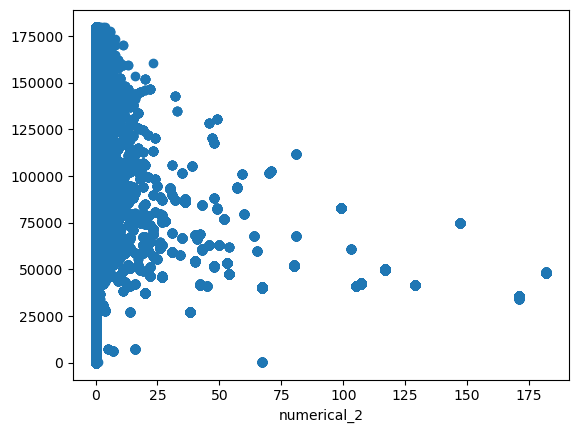

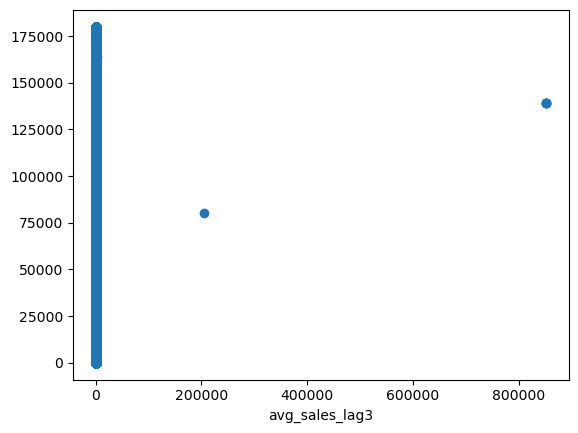

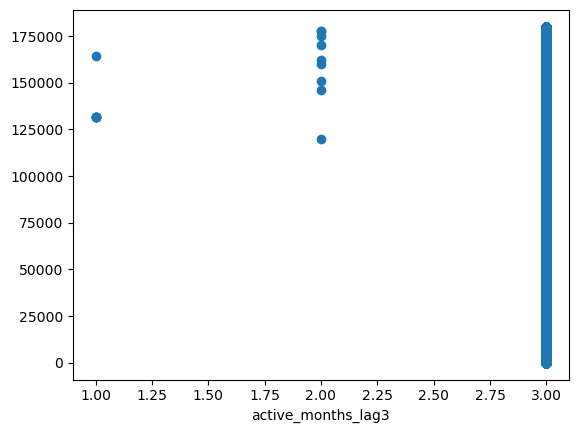

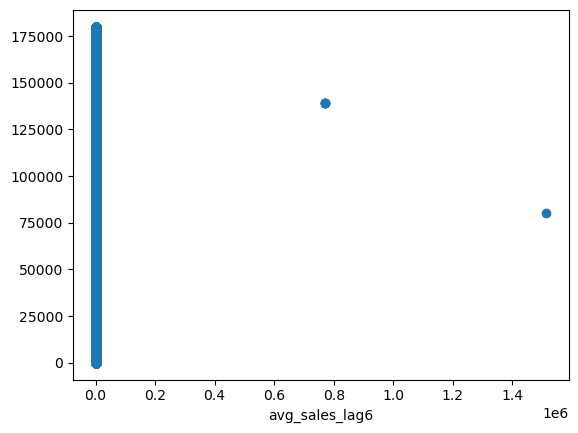

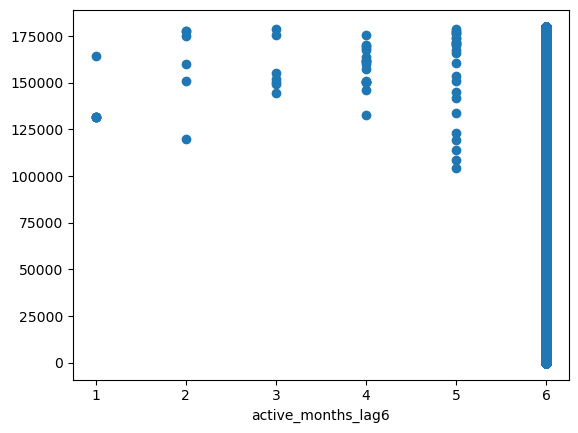

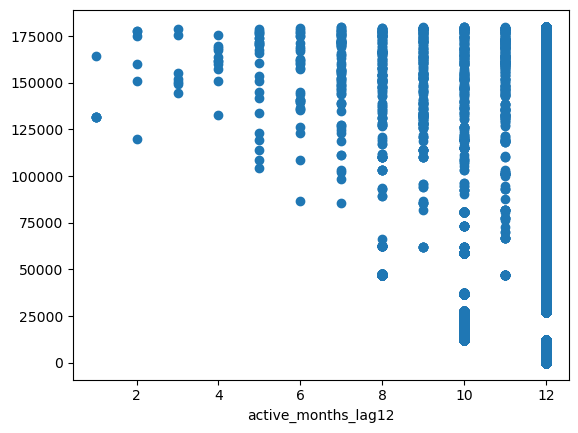

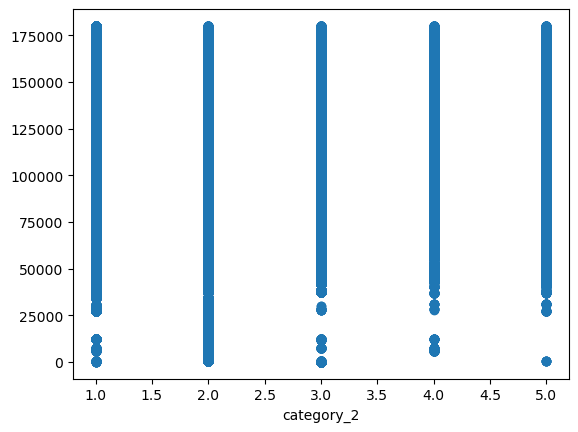

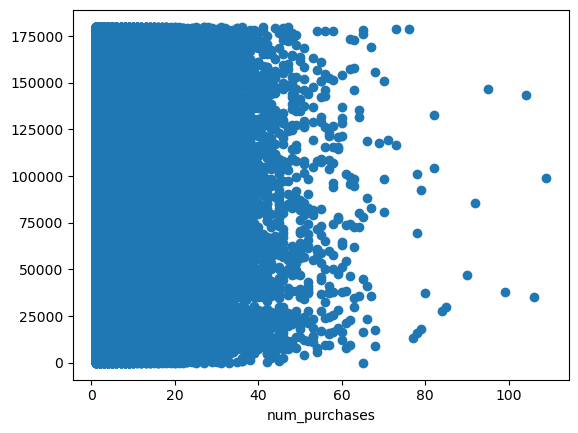

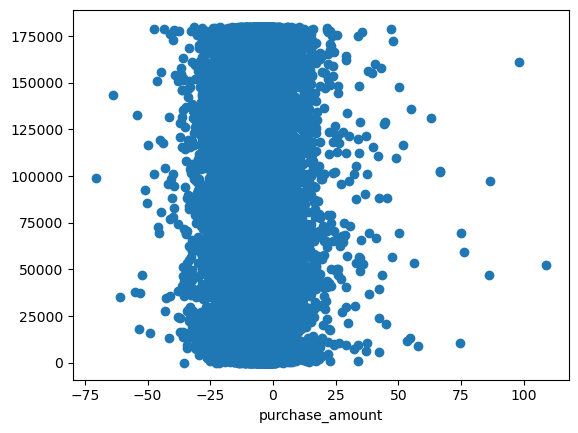

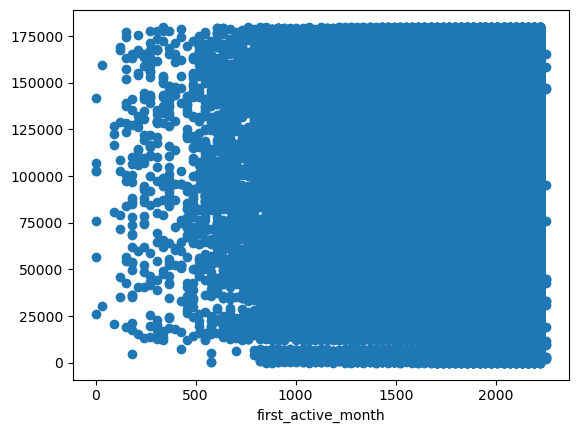

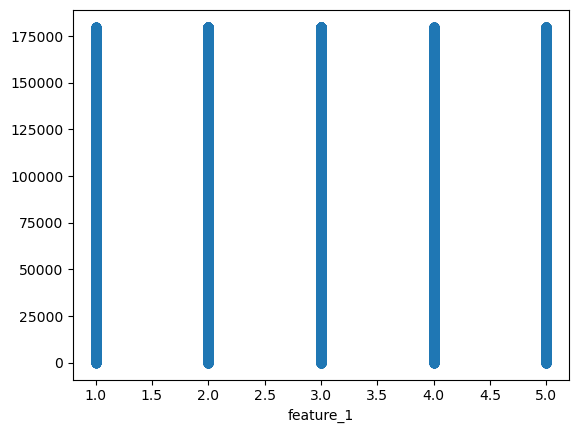

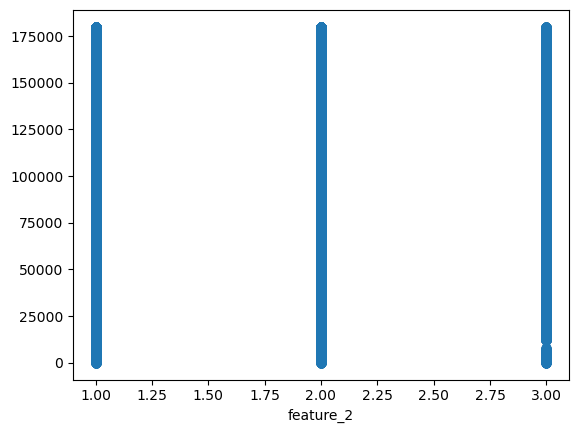

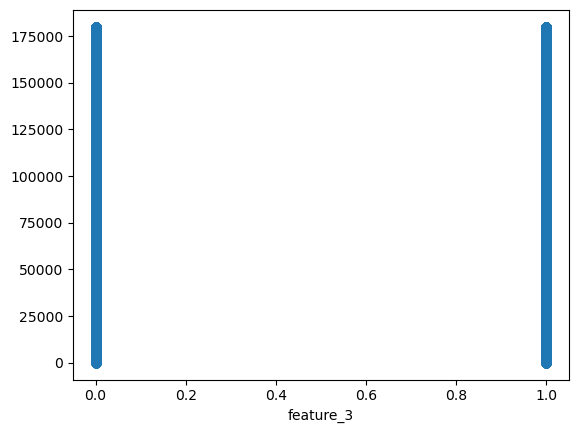

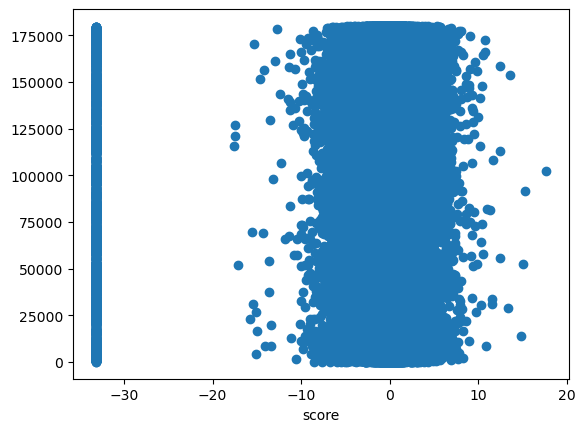

In [ ]:
# # Create a scatter plot for each feature
# for col in data.columns:
#     plt.scatter(data[col], range(len(data)))
#     plt.xlabel(col)
#     plt.show()

In [ ]:
# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['numerical_2'] - data['numerical_2'].mean()) / data['numerical_2'].std()
# data = data[data['z_score'].abs() < 3]

In [ ]:
# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['avg_sales_lag3'] - data['avg_sales_lag3'].mean()) / data['avg_sales_lag3'].std()
# data = data[data['z_score'].abs() < 3]

C:\Users\DEBI\AppData\Local\Temp\ipykernel_4416\554199302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['z_score'] = (data['avg_sales_lag3'] - data['avg_sales_lag3'].mean()) / data['avg_sales_lag3'].std()


In [ ]:

# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['active_months_lag3'] - data['active_months_lag3'].mean()) / data['active_months_lag3'].std()
# data = data[data['z_score'].abs() < 3]

In [ ]:

# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['avg_sales_lag6'] - data['avg_sales_lag6'].mean()) / data['avg_sales_lag6'].std()
# data = data[data['z_score'].abs() < 3]

In [ ]:
# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['active_months_lag6'] - data['active_months_lag6'].mean()) / data['active_months_lag6'].std()
# data = data[data['z_score'].abs() < 3]

C:\Users\DEBI\AppData\Local\Temp\ipykernel_4416\280552051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['z_score'] = (data['active_months_lag6'] - data['active_months_lag6'].mean()) / data['active_months_lag6'].std()


In [ ]:
# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['category_2'] - data['category_2'].mean()) / data['category_2'].std()
# data = data[data['z_score'].abs() < 3]

In [ ]:
# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['num_purchases'] - data['num_purchases'].mean()) / data['num_purchases'].std()
# data = data[data['z_score'].abs() < 3]

In [ ]:
# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['purchase_amount'] - data['purchase_amount'].mean()) / data['purchase_amount'].std()
# data = data[data['z_score'].abs() < 3]

In [ ]:
# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['first_active_month'] - data['first_active_month'].mean()) / data['first_active_month'].std()
# data = data[data['z_score'].abs() < 3]

In [ ]:
# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['feature_1'] - data['feature_1'].mean()) / data['feature_1'].std()
# data = data[data['z_score'].abs() < 3]

In [ ]:
# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['feature_2'] - data['feature_2'].mean()) / data['feature_2'].std()
# data = data[data['z_score'].abs() < 3]

In [ ]:
# # Remove outliers from the 'variable_name' column using z-score approach
# data['z_score'] = (data['feature_3'] - data['feature_3'].mean()) / data['feature_3'].std()
# data = data[data['z_score'].abs() < 3]

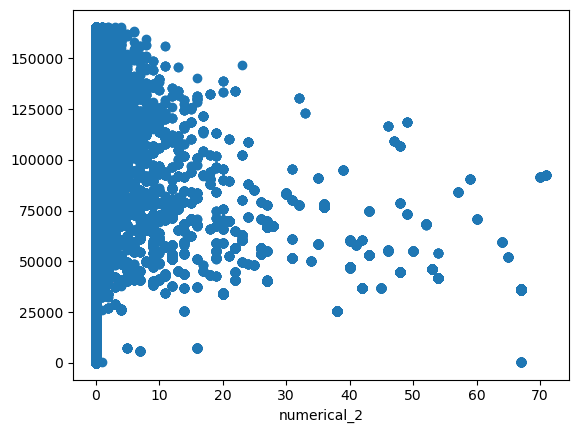

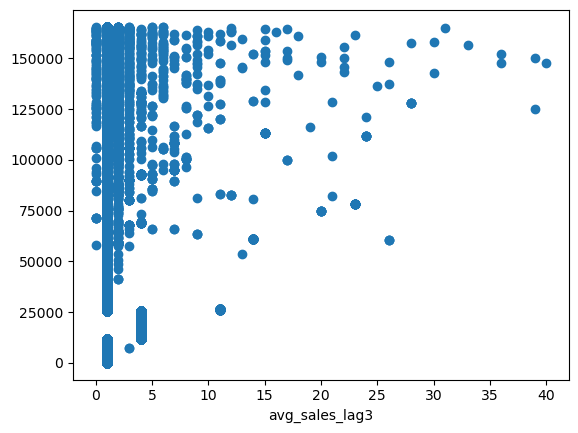

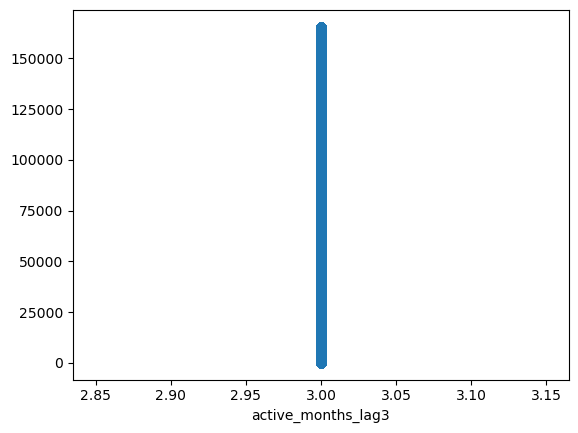

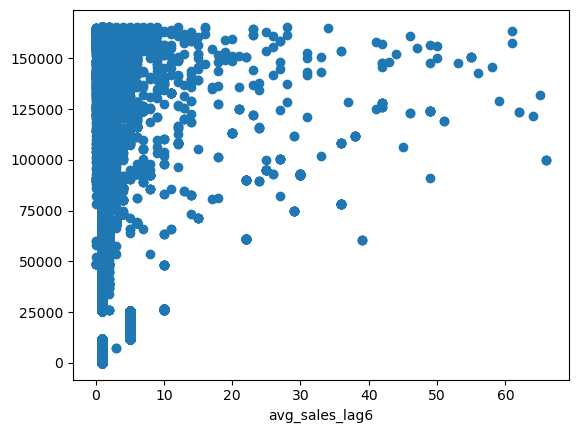

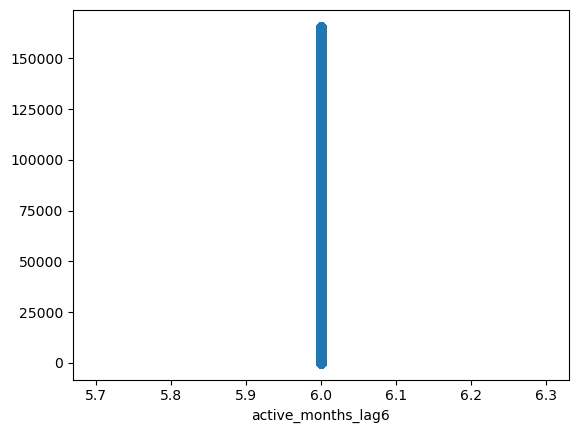

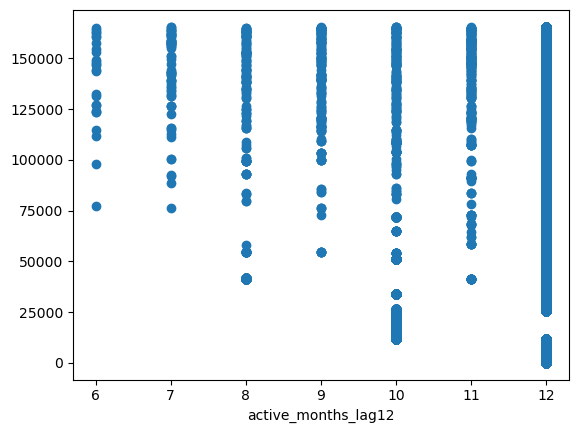

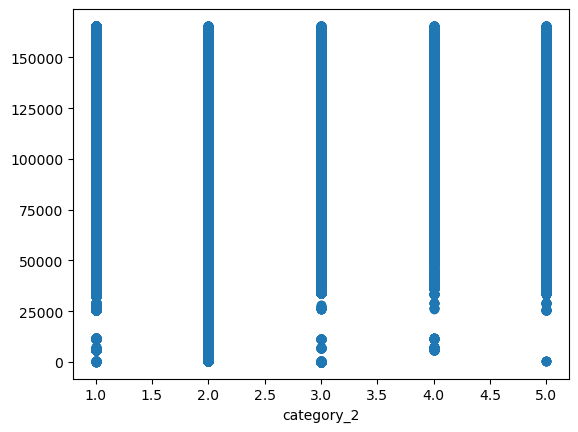

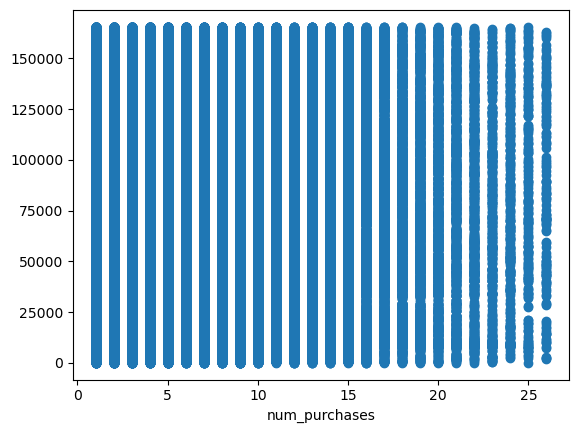

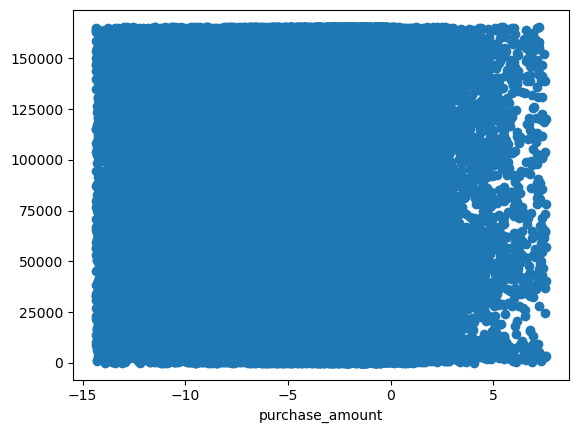

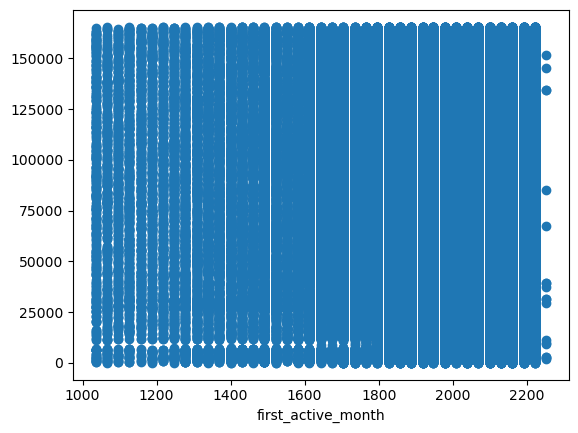

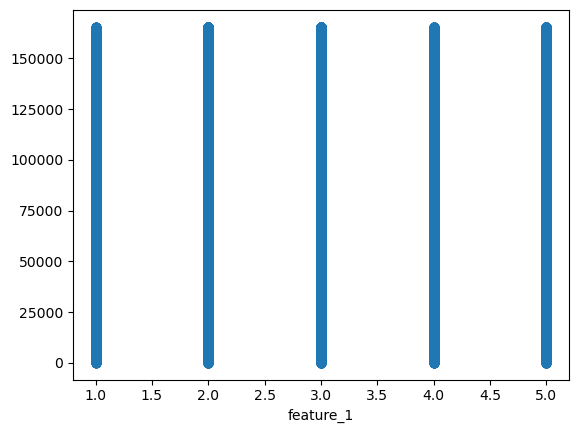

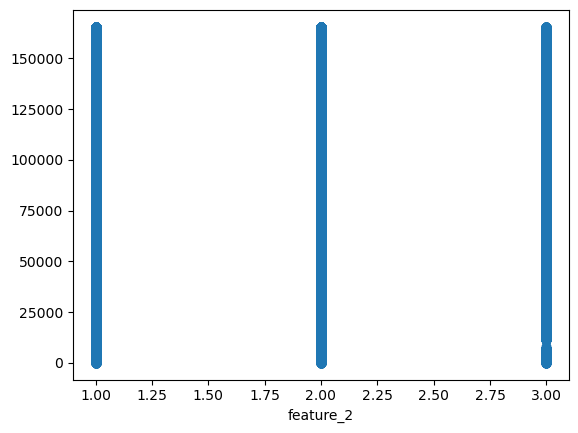

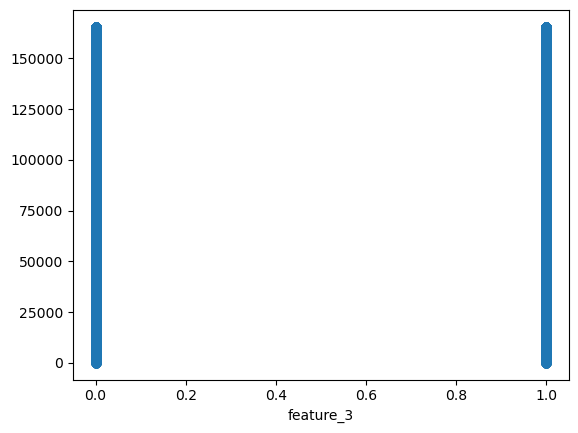

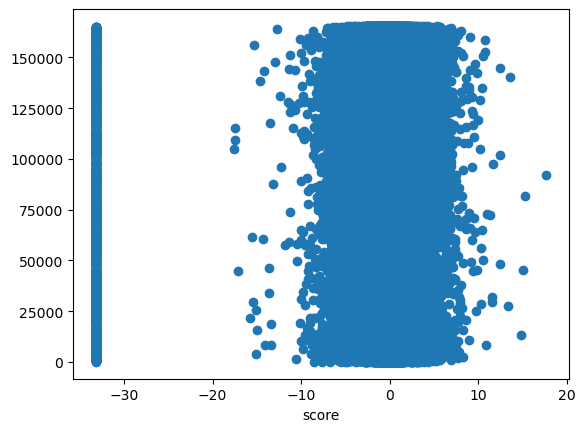

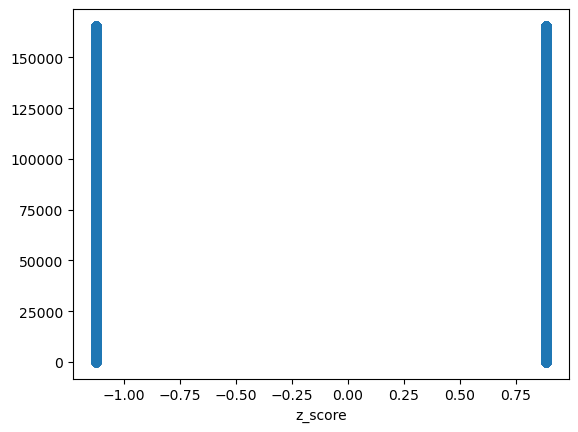

In [ ]:
# # Create a scatter plot for each feature
# for col in data.columns:
#     plt.scatter(data[col], range(len(data)))
#     plt.xlabel(col)
#     plt.show()

In [ ]:
data.describe(include="all")

,category_2_x,installments_x,category_3_x,authorized_flag,category_1_x,purchase_amount_x,feature_1,feature_2,feature_3,score,days_enrolled,num_purchases_x,category_2_y,installments_y,category_3_y,category_1_y,purchase_amount_y,num_purchases_y
count,178586.000000,178586.000000,178586.000000,178586.000000,178586.000000,1.785860e+05,178586.000000,178586.000000,178586.000000,178586.000000,178586.000000,178586.000000,178586.000000,178586.000000,178586.000000,178586.000000,178586.000000,178586.000000
mean,2.129999,59.434116,1.129999,0.009682,0.047243,1.493629e+01,3.097130,1.742970,0.563129,-0.443298,1911.287234,93.055587,2.102684,4.851450,0.575409,0.025489,-3.777736,6.635459
std,1.493509,100.252304,1.493509,0.097918,0.212160,1.428691e+04,1.187567,0.750827,0.496000,3.522269,290.095704,107.697281,1.488794,8.064263,0.601540,0.157606,4.303941,6.596935
min,1.000000,0.000000,0.000000,0.000000,0.000000,-2.088013e+03,1.000000,1.000000,0.000000,-33.219281,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-70.813489,1.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,-6.942682e+01,2.000000,1.000000,0.000000,-0.928418,1796.000000,28.000000,1.000000,0.000000,0.000000,0.000000,-5.239500,2.000000
50%,1.000000,16.000000,0.000000,0.000000,0.000000,-3.231047e+01,3.000000,2.000000,1.000000,-0.086215,1978.000000,57.000000,1.000000,1.000000,1.000000,0.000000,-2.685816,5.000000
75%,3.000000,80.000000,2.000000,0.000000,0.000000,-1.343507e+01,4.000000,2.000000,1.000000,0.664212,2131.000000,116.000000,3.000000,7.000000,1.000000,0.000000,-1.233714,9.000000
max,5.000000,1689.000000,4.000000,1.000000,1.000000,6.010596e+06,5.000000,3.000000,1.000000,17.675716,2253.000000,2912.000000,5.000000,154.000000,2.000000,1.000000,109.086210,109.000000


In [ ]:
data = data.drop('merchant_id', axis=1)

In [ ]:
data = data.drop('card_id', axis=1)

In [ ]:
X = data.drop('score', axis=1) # select all columns except the target column
y = data['score'] # select only the target column

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression()

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

RMSE: 3.5600581082894296


it seems that this trail resulted in higher square error so the first was better

In [ ]:
from sklearn.metrics import r2_score

r_score = r2_score(y_test, y_pred)

print("R score:", r_score)

R score: 0.00933032774466902


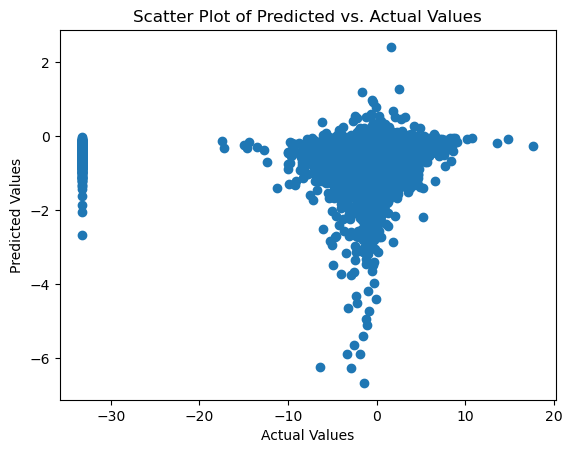

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs. Actual Values')
plt.show()

I will try different models

In [ ]:

from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE) of the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

RMSE: 5.2263975865004255


In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE) of the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

RMSE: 3.6162719099945093


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
param = { 'n_estimators':[50], 'learning_rate':[1e-2], 'loss':['exponential'] }
adaRegressor = AdaBoostRegressor(random_state = 10)

grid_ada = GridSearchCV(adaRegressor, param, cv = 3, n_jobs = -1, verbose=1)
grid_ada.fit(X_train, y_train)
y_pred_ada = grid_ada.predict(X_test)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
rmse = mean_squared_error(y_test, y_pred_ada, squared=False)
print('RMSE:', rmse)

RMSE: 3.561794647069195


In [ ]:
import timeit
from xgboost import XGBRegressor
start = timeit.default_timer()
xgb = XGBRegressor()
parameters = { 'gamma': [8], 'eval_metric' :['rmse'],'eta': [0.5], 'colsample_bytree':[0.3], 'min_child_weight': [3], 'max_depth' :[3,5,10], 'max_features':[50,100],'subsample': [0.7],'tree_method':['auto'], 'reg_alpha':[1000], "criterion": ["mse"],'n_estimators': [500,1000] ,'seed':[11] }

grid_xgb = GridSearchCV(xgb, parameters, cv = 3, n_jobs = -1, verbose=1)
grid_xgb.fit(X_train, y_train)
y_pred_xgb = grid_xgb.predict(X_test)

stop = timeit.default_timer()
execution_time = (stop - start)/60
print("Ensemble Executed in {} minutes".format(str(execution_time)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[04:18:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

Ensemble Executed in 2.3540648966668716 minutes


In [ ]:
rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
print('RMSE:', rmse)

RMSE: 3.5317867120368827


In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Convert the data to a LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Set the hyperparameters for the model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the LightGBM regressor on the training set
model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data], early_stopping_rounds=50)

# Make predictions on the testing set
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Calculate the root mean squared error (RMSE) of the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

C:\Users\DEBI\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 3.57394
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 3.57154
[3]	valid_0's rmse: 3.56948
[4]	valid_0's rmse: 3.56752
[5]	valid_0's rmse: 3.56518
[6]	valid_0's rmse: 3.56278
[7]	valid_0's rmse: 3.56066
[8]	valid_0's rmse: 3.55901
[9]	valid_0's rmse: 3.55739
[10]	valid_0's rmse: 3.55594
[11]	valid_0's rmse: 3.5549
[12]	valid_0's rmse: 3.55335
[13]	valid_0's rmse: 3.5522
[14]	valid_0's rmse: 3.55104
[15]	valid_0's rmse: 3.54988
[16]	valid_0's rmse: 3.54868
[17]	valid_0's rmse: 3.54776
[18]	valid_0's rmse: 3.54663
[19]	valid_0's rmse: 3.54595
[20]	valid_0's rmse: 3.54504
[21]	valid_0's rmse: 3.54442
[22]	valid_0's rmse: 3.54394
[23]	valid_0's rmse: 3.54323
[24]	valid_0's rmse: 3.54263
[25]	valid_0's rmse: 3.54

# <font color='840e15'> Q7 </font>

<AxesSubplot:>

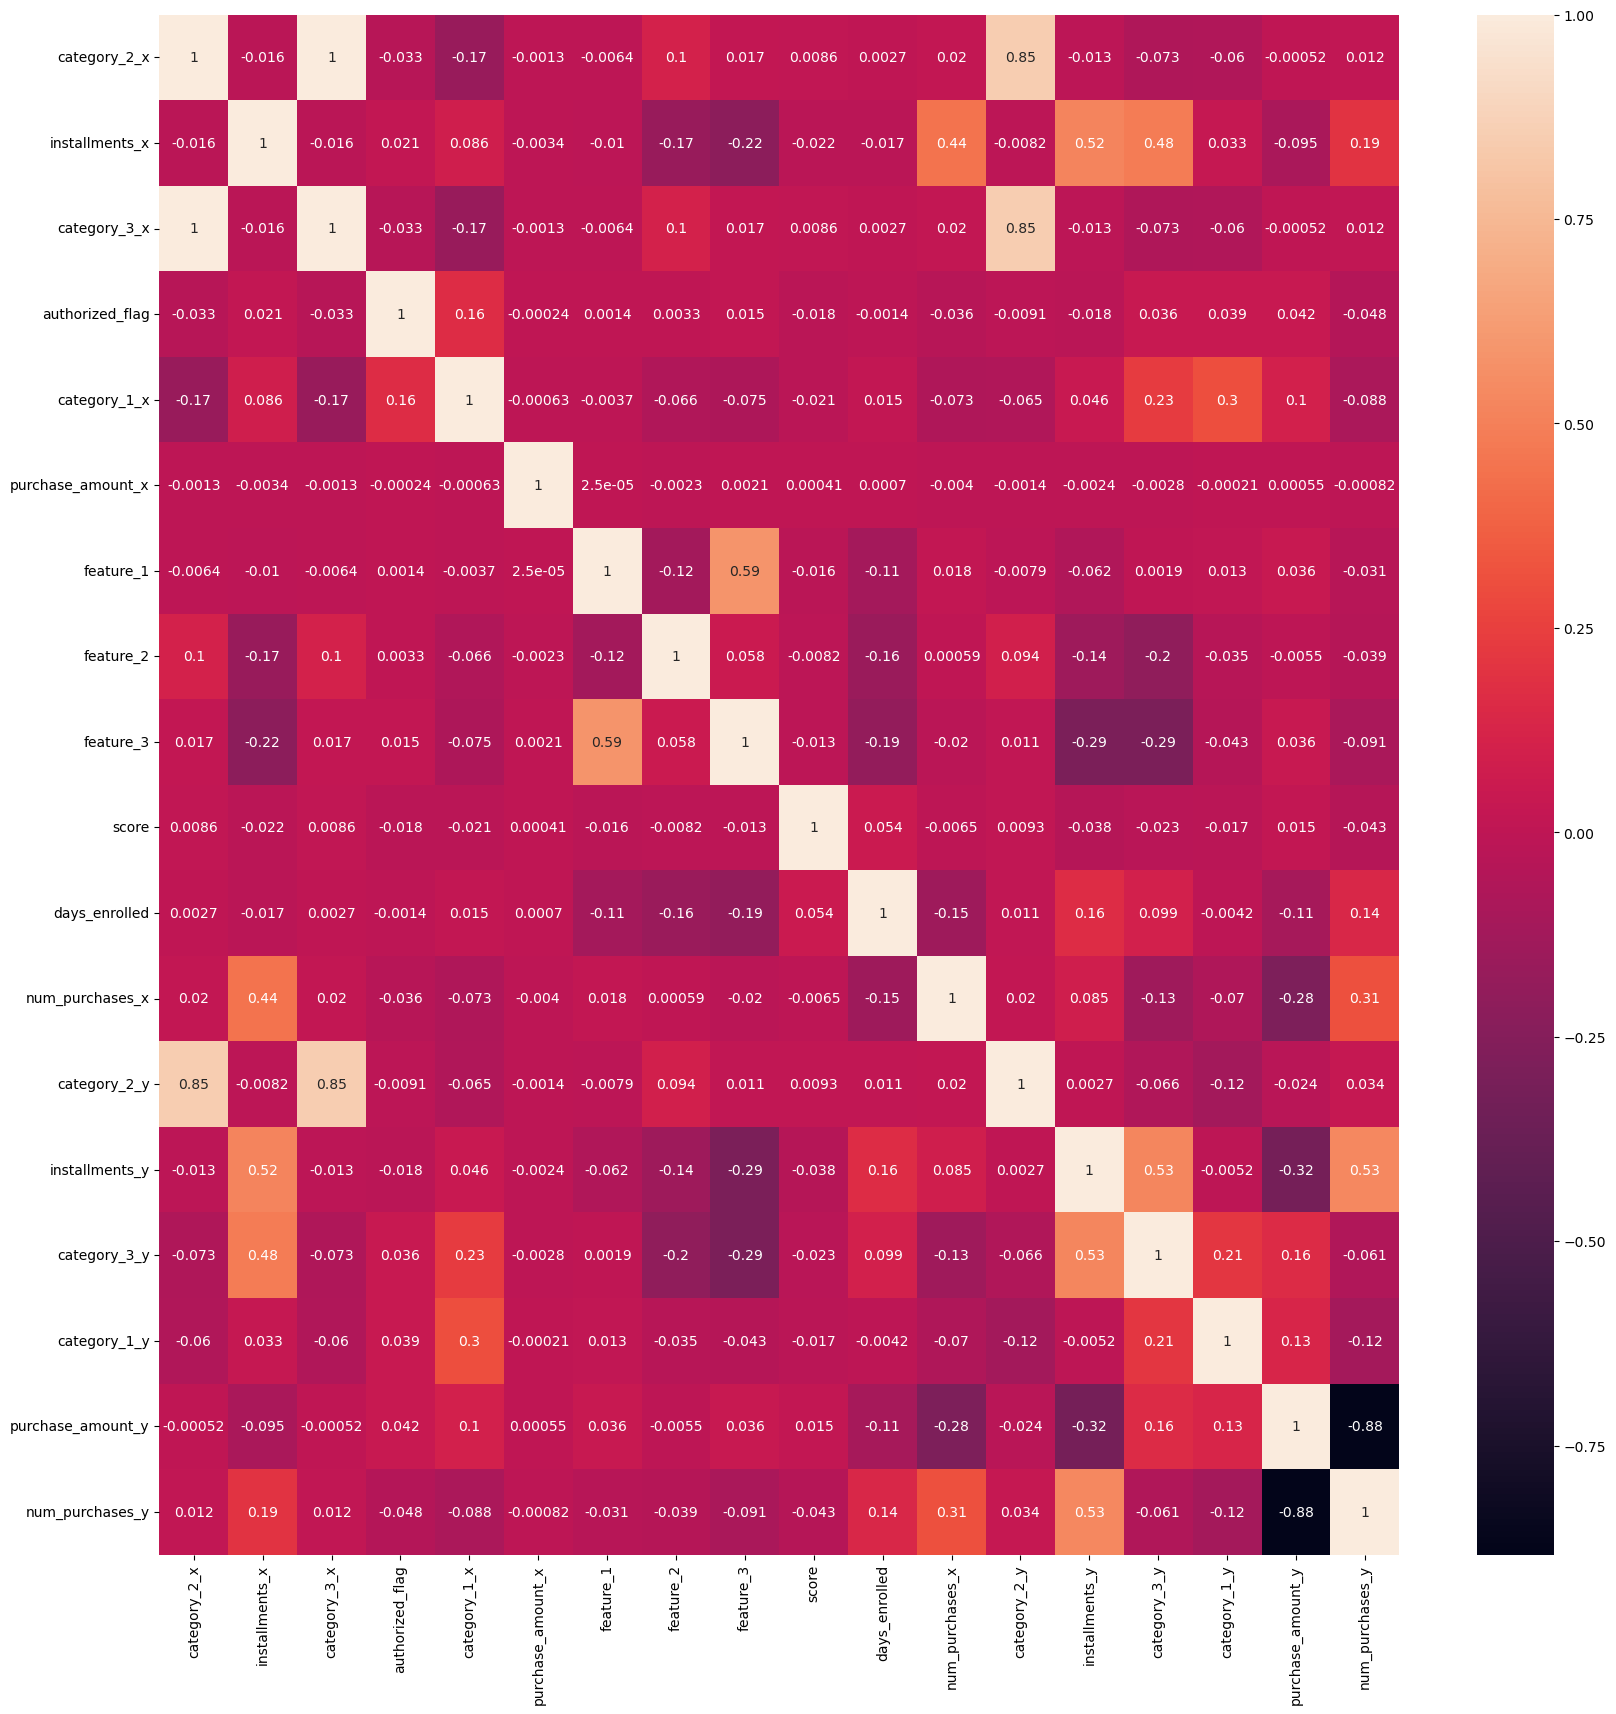

In [ ]:
# Compute the correlation matrix
corr_matrix = data.corr()

# Set the figure size
plt.figure(figsize=(20, 20))

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True)

* there are multicollinearity exists in some features in deed "category_2" and "category_3"
* also purchase amount of historical and that of new are highly correlated

# <font color='840e15'> Q8 </font>

# Pipeline Trail (2)

Through this trail i will take only important features in consideration, and drop others to see the effect

In [ ]:
userscore_df = pd.read_csv("Documents/Data_Analytics/data/userscore.csv")

In [ ]:
merchants_df = pd.read_csv("Documents/Data_Analytics/data/merchants.csv")

In [ ]:
historical_transactions_df = pd.read_csv("Documents/Data_Analytics/data/historical_transactions.csv")

In [ ]:
new_merchant_transactions_df = pd.read_csv("Documents/Data_Analytics/data/new_merchant_transactions.csv")

In [ ]:
userscore_df['first_active_month'] = pd.to_datetime(userscore_df['first_active_month'], format='%b-%y')

In [ ]:
userscore_df['first_active_month']

0        2017-06-01
1        2017-01-01
2        2016-08-01
3        2017-09-01
4        2017-11-01
            ...    
201912   2017-09-01
201913   2015-10-01
201914   2017-08-01
201915   2016-07-01
201916   2017-07-01
Name: first_active_month, Length: 201917, dtype: datetime64[ns]

In [ ]:
# getting the first date to consider it as a refrence date
first_date = userscore_df['first_active_month'].min()

# Print the first date
first_date

Timestamp('2011-11-01 00:00:00')

In [ ]:
# Convert the 'date_column' to number of days since January 1, 1970
ref_date = pd.to_datetime('2011-11-01')
userscore_df['days_enrolled'] = (pd.to_datetime(userscore_df['first_active_month']) - ref_date).dt.days

In [ ]:
userscore_df = userscore_df.drop('first_active_month', axis=1)

In [ ]:
userscore_df.columns

Index(['card_id', 'feature_1', 'feature_2', 'feature_3', 'score',
       'days_enrolled'],
      dtype='object')

In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['avg_sales_lag3'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['avg_sales_lag3'] = merchants_df['avg_sales_lag3'].fillna(mean)

In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['avg_sales_lag6'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['avg_sales_lag6'] = merchants_df['avg_sales_lag6'].fillna(mean)

In [ ]:
# Calculate the mean of 'column2'
mean = merchants_df['avg_sales_lag12'].mean()

# Replace missing values in 'column2' with the mean
merchants_df['avg_sales_lag12'] = merchants_df['avg_sales_lag12'].fillna(mean)

In [ ]:
# Calculate the mean of 'column2'
mean = historical_transactions_df['category_2'].mean()

# Replace missing values in 'column2' with the mean
historical_transactions_df['category_2'] = historical_transactions_df['category_2'].fillna(mean)

In [ ]:
# Calculate the mode of 'column2'
mode = historical_transactions_df['category_3'].mode()[0]

# Replace missing values in 'column2' with the mode
historical_transactions_df['category_3'] = historical_transactions_df['category_3'].fillna(mode)

In [ ]:
# for each card i need the number of purchases
historical_transactions_counts = historical_transactions_df.groupby('card_id')['purchase_date'].count().reset_index()

In [ ]:
historical_transactions_counts = historical_transactions_counts.rename(columns={'purchase_date': 'num_purchases'})

In [ ]:
historical_transactions_counts

,card_id,num_purchases
0,C_ID_00007093c1,149
1,C_ID_0001238066,123
2,C_ID_0001506ef0,66
3,C_ID_0001793786,216
4,C_ID_000183fdda,144
...,...,...
325535,C_ID_ffff1d9928,12
325536,C_ID_ffff579d3a,114
325537,C_ID_ffff756266,24
325538,C_ID_ffff828181,190


In [ ]:
# for each card i need the avergae amount of purchases
purchase_amount = historical_transactions_df.groupby('card_id')['purchase_amount'].sum().reset_index()

In [ ]:
purchase_amount

,card_id,purchase_amount
0,C_ID_00007093c1,-76.845041
1,C_ID_0001238066,-72.447201
2,C_ID_0001506ef0,-34.601879
3,C_ID_0001793786,-36.786013
4,C_ID_000183fdda,-68.837938
...,...,...
325535,C_ID_ffff1d9928,-7.477673
325536,C_ID_ffff579d3a,-80.292768
325537,C_ID_ffff756266,-5.506420
325538,C_ID_ffff828181,-120.099200


In [ ]:
# for each card i need the most merchant dealt with
grouped_data = historical_transactions_df.groupby('card_id')['merchant_id'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
# Print the mode of each group
print("Mode of 'your_data_column' by 'your_group_column':")
grouped_data.head(5)

Mode of 'your_data_column' by 'your_group_column':


,card_id,merchant_id
0,C_ID_00007093c1,M_ID_9400cf2342
1,C_ID_0001238066,M_ID_d17aabd756
2,C_ID_0001506ef0,M_ID_b1fc88154d
3,C_ID_0001793786,M_ID_923d57de8d
4,C_ID_000183fdda,M_ID_f9cfe0a43b


In [ ]:
grouped_data.head(20)

,card_id,merchant_id
0,C_ID_00007093c1,M_ID_9400cf2342
1,C_ID_0001238066,M_ID_d17aabd756
2,C_ID_0001506ef0,M_ID_b1fc88154d
3,C_ID_0001793786,M_ID_923d57de8d
4,C_ID_000183fdda,M_ID_f9cfe0a43b
5,C_ID_00024e244b,M_ID_8f71be2af9
6,C_ID_0002709b5a,M_ID_543dd11ce2
7,C_ID_00027503e2,M_ID_8de747a1c2
8,C_ID_000298032a,M_ID_8978193c15
9,C_ID_0002ba3c2e,M_ID_ec1175604c


In [ ]:
#all_merchant_features = pd.merge(grouped_data,features, on='merchant_id', how='inner')
all_merchant_features = pd.merge(grouped_data,merchants_df, on='merchant_id', how='inner')

In [ ]:
all_merchant_features .head(10)

,card_id,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,C_ID_00007093c1,M_ID_9400cf2342,60307,307,19,-0.047556,-0.057471,N,D,D,...,0.96,0.959246,6,1.02,0.990420,12,N,-1,2,3.0
1,C_ID_0d521d52b4,M_ID_9400cf2342,60307,307,19,-0.047556,-0.057471,N,D,D,...,0.96,0.959246,6,1.02,0.990420,12,N,-1,2,3.0
2,C_ID_2a08ddf33c,M_ID_9400cf2342,60307,307,19,-0.047556,-0.057471,N,D,D,...,0.96,0.959246,6,1.02,0.990420,12,N,-1,2,3.0
3,C_ID_4c6bd4d11c,M_ID_9400cf2342,60307,307,19,-0.047556,-0.057471,N,D,D,...,0.96,0.959246,6,1.02,0.990420,12,N,-1,2,3.0
4,C_ID_0001238066,M_ID_d17aabd756,28241,705,33,-0.057471,-0.057471,N,C,C,...,0.99,0.984455,6,1.03,0.990617,12,N,314,9,1.0
5,C_ID_0cdd0ebc44,M_ID_d17aabd756,28241,705,33,-0.057471,-0.057471,N,C,C,...,0.99,0.984455,6,1.03,0.990617,12,N,314,9,1.0
6,C_ID_32ed84d6a7,M_ID_d17aabd756,28241,705,33,-0.057471,-0.057471,N,C,C,...,0.99,0.984455,6,1.03,0.990617,12,N,314,9,1.0
7,C_ID_33a79fb391,M_ID_d17aabd756,28241,705,33,-0.057471,-0.057471,N,C,C,...,0.99,0.984455,6,1.03,0.990617,12,N,314,9,1.0
8,C_ID_9d617c017f,M_ID_d17aabd756,28241,705,33,-0.057471,-0.057471,N,C,C,...,0.99,0.984455,6,1.03,0.990617,12,N,314,9,1.0
9,C_ID_b29c7d0e9d,M_ID_d17aabd756,28241,705,33,-0.057471,-0.057471,N,C,C,...,0.99,0.984455,6,1.03,0.990617,12,N,314,9,1.0


In [ ]:
historical_per_card = pd.merge(historical_transactions_counts, purchase_amount, on='card_id', how='inner')

In [ ]:
historical_per_card.head(10)

,card_id,num_purchases,purchase_amount
0,C_ID_00007093c1,149,-76.845041
1,C_ID_0001238066,123,-72.447201
2,C_ID_0001506ef0,66,-34.601879
3,C_ID_0001793786,216,-36.786013
4,C_ID_000183fdda,144,-68.837938
5,C_ID_00024e244b,70,-41.552753
6,C_ID_0002709b5a,73,-47.659542
7,C_ID_00027503e2,42,-31.123047
8,C_ID_000298032a,30,-15.992416
9,C_ID_0002ba3c2e,70,-44.342996


In [ ]:
merchants_per_card = pd.merge(historical_per_card,all_merchant_features, on='card_id', how='inner')

In [ ]:
merchants_per_card.head(5)

,card_id,num_purchases,purchase_amount,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,C_ID_00007093c1,149,-76.845041,M_ID_9400cf2342,60307,307,19,-0.047556,-0.057471,N,...,0.96,0.959246,6,1.02,0.990420,12,N,-1,2,3.0
1,C_ID_0001238066,123,-72.447201,M_ID_d17aabd756,28241,705,33,-0.057471,-0.057471,N,...,0.99,0.984455,6,1.03,0.990617,12,N,314,9,1.0
2,C_ID_0001506ef0,66,-34.601879,M_ID_b1fc88154d,321,705,33,0.388700,-0.047556,N,...,1.02,1.087142,6,0.95,1.095145,12,Y,137,19,3.0
3,C_ID_0001793786,216,-36.786013,M_ID_923d57de8d,33837,705,33,-0.017811,-0.057471,N,...,1.02,1.011730,6,1.06,1.021055,12,Y,-1,24,2.0
4,C_ID_000183fdda,144,-68.837938,M_ID_f9cfe0a43b,13812,367,16,0.160657,-0.047556,N,...,1.02,1.027423,6,1.00,1.008010,12,Y,161,3,3.0


In [ ]:
merchants_per_card.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352393 entries, 0 to 352392
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   card_id                      352393 non-null  object 
 1   num_purchases                352393 non-null  int64  
 2   purchase_amount              352393 non-null  float64
 3   merchant_id                  352393 non-null  object 
 4   merchant_group_id            352393 non-null  int64  
 5   merchant_category_id         352393 non-null  int64  
 6   subsector_id                 352393 non-null  int64  
 7   numerical_1                  352393 non-null  float64
 8   numerical_2                  352393 non-null  float64
 9   category_1                   352393 non-null  object 
 10  most_recent_sales_range      352393 non-null  object 
 11  most_recent_purchases_range  352393 non-null  object 
 12  avg_sales_lag3               352393 non-null  float64
 13 

In [ ]:
mean = new_merchant_transactions_df['category_2'].mean()

# Replace missing values in 'column2' with the mean
new_merchant_transactions_df['category_2'] = new_merchant_transactions_df['category_2'].fillna(mean)

In [ ]:
# Calculate the mode of 'column2'
mode = new_merchant_transactions_df['category_3'].mode()[0]

# Replace missing values in 'column2' with the mode
new_merchant_transactions_df['category_3'] = new_merchant_transactions_df['category_3'].fillna(mode)

In [ ]:
new_transactions_counts = new_merchant_transactions_df.groupby('card_id')['purchase_date'].count().reset_index()

In [ ]:
new_transactions_counts = new_transactions_counts.rename(columns={'purchase_date': 'num_purchases_new'})

In [ ]:
new_transactions_counts

,card_id,num_purchases_new
0,C_ID_00007093c1,2
1,C_ID_0001238066,26
2,C_ID_0001506ef0,2
3,C_ID_0001793786,31
4,C_ID_000183fdda,11
...,...,...
289996,C_ID_ffff1d9928,4
289997,C_ID_ffff579d3a,1
289998,C_ID_ffff756266,1
289999,C_ID_ffff828181,8


In [ ]:
# for each card i need the avergae amount of purchases
purchase_amount_new = new_merchant_transactions_df.groupby('card_id')['purchase_amount'].sum().reset_index()

In [ ]:
purchase_amount_new

,card_id,purchase_amount
0,C_ID_00007093c1,-1.328524
1,C_ID_0001238066,-14.850055
2,C_ID_0001506ef0,-1.447354
3,C_ID_0001793786,-0.229620
4,C_ID_000183fdda,-6.590778
...,...,...
289996,C_ID_ffff1d9928,-2.460351
289997,C_ID_ffff579d3a,-0.664262
289998,C_ID_ffff756266,0.378578
289999,C_ID_ffff828181,-4.964204


In [ ]:
new_per_card = pd.merge(new_transactions_counts, purchase_amount_new, on='card_id', how='inner')

In [ ]:
new_per_card.head(10)

,card_id,num_purchases_new,purchase_amount
0,C_ID_00007093c1,2,-1.328524
1,C_ID_0001238066,26,-14.850055
2,C_ID_0001506ef0,2,-1.447354
3,C_ID_0001793786,31,-0.229620
4,C_ID_000183fdda,11,-6.590778
5,C_ID_0002709b5a,3,-2.018827
6,C_ID_000298032a,1,-0.641872
7,C_ID_0002ba3c2e,3,-2.071059
8,C_ID_0002c7c2c1,6,-3.929448
9,C_ID_00032df08f,8,-2.791535


In [ ]:
new_per_card.columns

Index(['card_id', 'num_purchases_new', 'purchase_amount'], dtype='object')

In [ ]:
card_data = pd.merge(merchants_per_card,new_per_card, on='card_id', how='inner')

In [ ]:
card_data.head(10)

,card_id,num_purchases,purchase_amount_x,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,...,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2,num_purchases_new,purchase_amount_y
0,C_ID_00007093c1,149,-76.845041,M_ID_9400cf2342,60307,307,19,-0.047556,-0.057471,N,...,6,1.02,0.990420,12,N,-1,2,3.0,2,-1.328524
1,C_ID_0001238066,123,-72.447201,M_ID_d17aabd756,28241,705,33,-0.057471,-0.057471,N,...,6,1.03,0.990617,12,N,314,9,1.0,26,-14.850055
2,C_ID_0001506ef0,66,-34.601879,M_ID_b1fc88154d,321,705,33,0.388700,-0.047556,N,...,6,0.95,1.095145,12,Y,137,19,3.0,2,-1.447354
3,C_ID_0001793786,216,-36.786013,M_ID_923d57de8d,33837,705,33,-0.017811,-0.057471,N,...,6,1.06,1.021055,12,Y,-1,24,2.0,31,-0.229620
4,C_ID_000183fdda,144,-68.837938,M_ID_f9cfe0a43b,13812,367,16,0.160657,-0.047556,N,...,6,1.00,1.008010,12,Y,161,3,3.0,11,-6.590778
5,C_ID_0002709b5a,73,-47.659542,M_ID_543dd11ce2,60363,705,33,-0.027726,-0.057471,N,...,6,1.11,1.095600,12,N,-1,21,5.0,3,-2.018827
6,C_ID_000298032a,30,-15.992416,M_ID_8978193c15,7153,763,36,-0.057471,-0.057471,N,...,6,1.10,0.927917,12,N,233,9,1.0,1,-0.641872
7,C_ID_0002ba3c2e,70,-44.342996,M_ID_ec1175604c,32598,705,33,-0.057471,-0.057471,N,...,6,0.93,0.958456,12,N,-1,18,2.0,3,-2.071059
8,C_ID_0002c7c2c1,67,-44.183670,M_ID_f40ccc1312,35,178,29,74.324142,67.443198,N,...,6,1.20,1.229338,12,Y,69,9,1.0,6,-3.929448
9,C_ID_00032df08f,145,-53.015743,M_ID_e93df2c7cc,88658,398,17,-0.057471,-0.057471,Y,...,6,0.89,0.955315,12,Y,-1,-1,NaN,8,-2.791535


In [ ]:
data = pd.merge(card_data,userscore_df, on='card_id', how='inner')

In [ ]:
data = data.drop('category_1', axis=1)

In [ ]:
data = data.drop('most_recent_sales_range', axis=1)

In [ ]:
data = data.drop('most_recent_purchases_range', axis=1)

In [ ]:
# drop the non helpful attributes
data = data.drop('card_id', axis=1)

In [ ]:
data = data.drop('merchant_id', axis=1)

In [ ]:
data = data.drop('subsector_id', axis=1)

In [ ]:
data = data.drop('state_id', axis=1)

In [ ]:
data = data.drop('city_id', axis=1)

In [ ]:
data = data.drop('merchant_group_id', axis=1)

In [ ]:
data = data.drop('merchant_category_id', axis=1)

In [ ]:
data.columns

Index(['num_purchases', 'purchase_amount_x', 'numerical_1', 'numerical_2',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'category_2', 'num_purchases_new', 'purchase_amount_y',
       'feature_1', 'feature_2', 'feature_3', 'score', 'days_enrolled'],
      dtype='object')

In [ ]:
X = data.drop('score', axis=1) # select all columns except the target column
y = data['score'] # select only the target column

In [ ]:
mean = X['category_2'].mean()

# Replace missing values in 'column2' with the mean
X['category_2'] = X['category_2'].fillna(mean)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195379 entries, 0 to 195378
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   num_purchases        195379 non-null  int64  
 1   purchase_amount_x    195379 non-null  float64
 2   numerical_1          195379 non-null  float64
 3   numerical_2          195379 non-null  float64
 4   avg_sales_lag3       195379 non-null  float64
 5   avg_purchases_lag3   195379 non-null  float64
 6   active_months_lag3   195379 non-null  int64  
 7   avg_sales_lag6       195379 non-null  float64
 8   avg_purchases_lag6   195379 non-null  float64
 9   active_months_lag6   195379 non-null  int64  
 10  avg_sales_lag12      195379 non-null  float64
 11  avg_purchases_lag12  195379 non-null  float64
 12  active_months_lag12  195379 non-null  int64  
 13  category_4           195379 non-null  object 
 14  category_2           195379 non-null  float64
 15  num_purchases_new

In [ ]:
X = X.drop('category_4', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.head()

,num_purchases,purchase_amount_x,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_2,num_purchases_new,purchase_amount_y,feature_1,feature_2,feature_3,days_enrolled
0,149,-76.845041,-0.047556,-0.057471,0.88,0.880170,3,0.96,0.959246,6,1.02,0.990420,12,3.000000,2,-1.328524,5,1,1,1919
1,66,-34.601879,0.388700,-0.047556,1.00,1.066087,3,1.02,1.087142,6,0.95,1.095145,12,3.000000,2,-1.447354,2,2,0,1704
2,144,-68.837938,0.160657,-0.047556,1.05,1.056556,3,1.02,1.027423,6,1.00,1.008010,12,3.000000,11,-6.590778,4,1,0,2131
3,67,-44.183670,74.324142,67.443198,1.11,1.139873,3,1.15,1.174748,6,1.20,1.229338,12,1.000000,6,-3.929448,3,2,1,1978
4,171,-101.899780,-0.057471,-0.057471,0.93,0.984479,3,0.84,0.940188,6,0.75,0.909884,12,2.284688,6,-3.441312,2,3,0,2100


In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression()

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

RMSE: 1.1633538290389736e-14


it seems that this trail resulted in higher square error so the first was better

In [ ]:
from sklearn.metrics import r2_score

r_score = r2_score(y_test, y_pred)

print("R score:", r_score)

R score: 1.0


* wooooow I'm so so so happy :)

it seems that both training and test error decreased and the model best fits the data